## Vincent T. Cooper ##
#### Start: 13 May 2021 ##
In this notebook, I preprocess results from the updated version of the coupled wave-ice model.
The goal is to get the data into the same format as the past version, so that I can:  
1 Run the distance-from-ice-edge calculation on new model results, and  
2 Repeat the past analysis outputs, which require the distance grouping.

In [1]:
import numpy as np
import os
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
# from matplotlib.colors import DivergingNorm
# import matplotlib.patches as patches
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns; sns.set(color_codes=False)
import cmocean
# from windrose import WindroseAxes
import warnings

import cftime
import datetime


plt.rcParams['xtick.bottom'] = True # keep my tick marks
plt.rcParams['ytick.left'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["font.family"] = "Arial"
# plt.rcParams['figure.figsize'] = 12,8
# mpl.rcParams['figure.dpi'] = 300 # activate for presentation quality

from sklearn.metrics.pairwise import haversine_distances

## this is a dummy grid that has the right conventions
grid = xr.open_dataset(
    '/glade/work/vcooper/grid_ref/sithick_SImon_CESM2_piControl_r1i1p1f1_gn_110001-120012.nc')

## circle boundary for plotting
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'sithick' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


In [2]:
##### MODEL DATA #####
mdir = '/glade/work/lettier/CICE/cicefsdww3i_output_concat/' ## location of file before changing dim names
mdir_adj = '/glade/u/home/vcooper/work/BGEP_vtc/adjfiles/' # location of adjusted files, changed dims to lat and lon
timeslice1719 = slice('2017-01-01','2019-12-31')
latslice = slice(300,384)

## output from distance calculation, using wavewatch data originally
dist_model = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/model_iceedgedistance_2000-2019.nc') 

## keep cice 2018 output because of detailed grid
cice18 = xr.open_dataset(mdir_adj + 'cicefsdww3i.cice.h1.0086.nc') # 2018 rerun
cice18.TLAT[:] = grid.lat # hack to fix polar stereo
cice18.TLON[:] = grid.lon
tarea = cice18.tarea.rename(
    {'TLON':'longitude','TLAT':'latitude'}).reset_coords(names=['ULON','ULAT'],drop=True)

## wavewatch output
ww1719ef = xr.open_dataset(mdir_adj + 'ww3.2017-2019_ef.nc').set_coords(['longitude','latitude'])

## wavewatch results excl. spectra
ww0019 = xr.open_dataset(
    '/glade/work/vcooper/BGEP_vtc/cicefsdww3i.ww3.sigheight.2000-2019.nc').set_coords(
    ['longitude','latitude']) # 6 hourly
xr.merge([ww0019,tarea],compat='override') # disagreements on latitude fill values, seems to be no factor

## revised mask for beaufort (post AGU poster)
latmin = 72
latmax = 79
lonmin = 195
lonmax = 230
beau_mask = (
    (dist_model.coords['longitude'] > lonmin) 
    & (dist_model.coords['longitude'] < lonmax)
    & (dist_model.coords['latitude'] > latmin)
    & (dist_model.coords['latitude'] < latmax)
)

## wavewatch spectra, only have '17-'19
ww1719beau = ww0019.sel(time=timeslice1719,nj=latslice)
ww1719beau.coords['mask'] = (('nj','ni'), beau_mask)
dist_model.coords['mask'] = (('nj','ni'), beau_mask)

dist1719beau = dist_model.sel(time=timeslice1719)
dist1719beau = dist1719beau.where(dist1719beau.mask > 0, drop=True)

ww1719beau_cat = xr.open_dataset('./ww1719beau_cat.nc')
ww1719beau_cat = ww1719beau_cat.where((
    ww1719beau_cat.longitude > lonmin) 
    & (ww1719beau_cat.longitude < lonmax)
    & (ww1719beau_cat.latitude > latmin)
    & (ww1719beau_cat.latitude < latmax),
    drop=True)

ww1719ef_beau_cat = xr.open_dataset('./ww1719ef_beau_cat.nc')
ww1719ef_beau_cat = ww1719ef_beau_cat.where((
    ww1719ef_beau_cat.longitude > lonmin) 
    & (ww1719ef_beau_cat.longitude < lonmax)
    & (ww1719ef_beau_cat.latitude > latmin)
    & (ww1719ef_beau_cat.latitude < latmax),
    drop=True)

ww1719beau_cat['dist'] = dist1719beau

######################

##### SATELLITE OBS from NSIDC, regridded to match CICE grid #####
path = '/glade/work/vcooper/BGEP_vtc/regrid_sat/' ## location of regridded file
ice_file = 'seaice_conc_daily_nh_1979-2019_cicegrid.nc' # name of regridded file
ice_file_originalgrid = 'seaice_conc_daily_nh_1979-2019.nc' # name of original file
boot = (xr.open_dataset(path+ice_file)).rename_vars(seaice_conc_cdr='aice_d')
# boot_native = (xr.open_dataset(path+ice_file_originalgrid)).rename_vars(seaice_conc_cdr='aice_d')

## pre-calculated distance from ice edge for satellite data
dist_sat = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_2012-2019.nc').rename('cdr').to_dataset()
dist_sat_bt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_bt_2012-2019.nc').rename('bt').to_dataset()
dist_sat_nt = xr.open_dataarray(
    '/glade/work/vcooper/BGEP_vtc/sat_iceedgedistance_nt_2012-2019.nc').rename('nt').to_dataset()
dist_sat_all = xr.merge([dist_sat,dist_sat_bt,dist_sat_nt],)

## fix grid
dist_sat_all.TLON[:] = ww0019.sel(nj=latslice).longitude.values
dist_sat_all.TLAT[:] = ww0019.sel(nj=latslice).latitude.values

#############################################################


##### IN SITU OBSERVATIONS #####
## read in new mooring data revised by Jim Thomson Sep 2020
BGOS_dir = '/glade/work/vcooper/BGEP_vtc/BGOS-AWAC_resultsv02/'
bgosA = xr.open_dataset(BGOS_dir + 'BGOS-A_AWAC.mat_converted.nc')
bgosD = xr.open_dataset(BGOS_dir + 'BGOS-D_AWAC.mat_converted.nc')

## read in latest SODA data on waves
sodaA = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_A_sigWaves.mat_converted_2020-07-27.nc')
sodaB = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_B_sigWaves.mat_converted_2020-07-27.nc')
sodaC = xr.open_dataset('/glade/work/vcooper/BGEP_vtc/SODA/2020-07-27_R0/SODA_C_sigWaves.mat_converted_2020-07-27.nc')

## SWIFT buoys
swiftpath = '/glade/work/lettier/SWIFT_SeaState2015/'
swift_files = ('SWIFT13_11-14Oct2015_30min_converted.nc','SWIFT11_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT09_06-08Oct2015_30min_converted.nc','SWIFT15_23-25Oct2015_30min_converted.nc',
              'SWIFT12_02Oct2015_30min_converted.nc','SWIFT11_23-24Oct2015_30min_converted.nc',
              'SWIFT09_11-14Oct2015_30min_converted.nc','SWIFT11_10Oct2015_30min_converted.nc',
              'SWIFT14_23-24Oct2015_30min_converted.nc','SWIFT09_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT12_23-24Oct2015_30min_converted.nc','SWIFT15_11-13Oct2015_30min_converted.nc',
              'SWIFT14_10Oct2015_30min_converted.nc','SWIFT09_02Nov2015_30min_converted.nc',
              'SWIFT14_04Oct2015_30min_converted.nc','SWIFT13_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT14_11-13Oct2015_30min_converted.nc','SWIFT13_23-24Oct2015_30min_converted.nc',
              'SWIFT14_16-18Oct2015_30min_converted.nc','SWIFT15_31Oct-01Nov2015_30min_converted.nc',
              'SWIFT11_16-18Oct2015_30min_converted.nc','SWIFT11_11-14Oct2015_30min_converted.nc',
              'SWIFT09_23-24Oct2015_30min_converted.nc','SWIFT11_04Oct2015_30min_converted.nc',
              'SWIFT12_11-14Oct2015_30min_converted.nc','SWIFT12_04Oct2015_30min_converted.nc',
              'SWIFT12_06-08Oct2015_30min_converted.nc')

swift_files = sorted(swift_files)  # sorted list of all SWIFT files
swift_names = swift_files # initialize list of shortened names for use as xarray data
swift_dict = {}
nswift = len(swift_names)

for i, file in enumerate(swift_files):
    swift_names[i] = file[:-19] # drops final 19 chars
    swift_dict[swift_names[i]] = xr.open_dataset(swiftpath + file) # datasets for each file, key to swift_names

swift_dist = {} # new dictionary to hold distances for swifts
swift_dist_bt = {} 
swift_dist_nt = {} 

## shortcut dictionary to index grid cells of in situ obs
nj = {}
nj['bds12'] = 349
nj['bds15'] = 350
nj['bds17'] = 349
nj['bds18'] = 349
nj['bgosA'] = 349
nj['bgosD'] = 350
nj['sodaA'] = 347
nj['sodaB'] = 351
nj['sodaC'] = 356

ni = {}
ni['bds12'] = 206
ni['bds15'] = 214
ni['bds17'] = 206
ni['bds18'] = 206
ni['bgosA'] = 206
ni['bgosD'] = 214
ni['sodaA'] = 209
ni['sodaB'] = 208
ni['sodaC'] = 207

for key,da in swift_dict.items():
    
    ## code to find model grid cell closest to lat lon of obs
    templat = np.tile(da.lat.values.mean(),
                  cice18.TLAT.values.size).reshape(cice18.TLAT.values.shape)
    templon = np.tile(da.lon.values.mean(),
                      cice18.TLON.values.size).reshape(cice18.TLON.values.shape) + 360
    difflat = templat - cice18.TLAT.values
    difflon = templon - cice18.TLON.values
    dist = difflat**2 + difflon**2
    njtemp = np.where(dist == np.min(dist))[0][0]
    nitemp = np.where(dist == np.min(dist))[1][0]
    nj[key] = njtemp
    ni[key] = nitemp

################################

## Scratch mess of preprocessing

In [40]:
%%time
###### Coupled Model Update May 2021 #####
## loading in and concat data 
ww2012 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012.nc')
ww2013 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2013.nc')
ww2014 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2014.nc')
ww2015 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2015.nc')
ww2016 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2016.nc')
ww2017 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2017.nc')
ww2018 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2018.nc')
ww2019 = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2019.nc')

ww_dict = {'ww2012' : ww2012,
           'ww2013' : ww2013,
           'ww2014' : ww2014,
           'ww2015' : ww2015,
           'ww2016' : ww2016,
           'ww2017' : ww2017,
           'ww2018' : ww2018,
           'ww2019' : ww2019}

temp_f = xr.open_dataset('./ww1719ef_beau_cat.nc')

for key,val in ww_dict.items():
    print(key)
    val = val.rename({'UAX': 'uwnd',
                'UAY': 'vwnd',
                'ICE': 'ice',
                'HS':  'hs',
                'T02': 't02',
                'T0M1':'t0m1',
                'T01': 't01',
                'FP0': 'fp',
                'THM': 'dir',
                'EF':  'ef',
                'FREQ':'f',
                'NX':  'ni',
                'NY':  'nj'})

    val['latitude'] = (['nj','ni'],grid.lat.values)
    val['longitude'] = (['nj','ni'],grid.lon.values)
    val = val.set_coords(['time','latitude','longitude'])
    val['f'] = temp_f.f
    val = val.sel(nj=latslice)
    val.coords['mask'] = (('nj','ni'), beau_mask)
    val = val.where(val.mask > 0, drop=True)
    ww_dict[key] = val

##########################################

ww2012
ww2013
ww2014
ww2015
ww2016
ww2017
ww2018
ww2019
CPU times: user 7 s, sys: 34.2 s, total: 41.2 s
Wall time: 3min 23s


In [48]:
%%time
ww_allbeau = xr.concat([ww_dict['ww2012'],
                        ww_dict['ww2013'],
                        ww_dict['ww2014'],
                        ww_dict['ww2015'],
                        ww_dict['ww2016'],
                        ww_dict['ww2017'],
                        ww_dict['ww2018'],
                        ww_dict['ww2019']],dim='time')

CPU times: user 1.66 s, sys: 4.77 s, total: 6.43 s
Wall time: 7.42 s


In [54]:
%%time
## save netcdf
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.beau.nc'
print ('saving to ', new_filename)

ww_allbeau.to_netcdf(path=new_filename)
print ('finished saving')

saving to  /glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.beau.nc
finished saving
CPU times: user 30.6 ms, sys: 1.25 s, total: 1.28 s
Wall time: 2.81 s


In [17]:
hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'

/glade/scratch/bitz/cesm23iws1tsks/run/hourly/cesm23iws1tsks.ww3.hi.2012-01-01*.nc


In [18]:
ww2012 = xr.open_mfdataset(path_pre_year + '2012-01-01*.nc',combine='nested',concat_dim='time')
ww2012

<xarray.Dataset>
Dimensions:  (FREQ: 25, NX: 320, NY: 384, time: 24)
Dimensions without coordinates: FREQ, NX, NY, time
Data variables:
    UAX      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    UAY      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ICE      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    HS       (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T02      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T0M1     (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T01      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    FP0      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    THM      (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    EF       (time, FREQ, NY, NX) float32 dask.array<chunksize=(1, 25, 384, 320), meta=np.ndarray>

In [38]:
## add latitude and longitude coords
ww2012 = xr.open_mfdataset(path_pre_year + '2012-01-01*.nc',
                           combine='nested',concat_dim='time')
ww2012['latitude'] = (['NY','NX'],grid.lat.values)
ww2012['longitude'] = (['NY','NX'],grid.lon.values)
ww2012 = ww2012.set_coords(['latitude','longitude'])

<xarray.Dataset>
Dimensions:    (FREQ: 25, NX: 320, NY: 384, time: 24)
Coordinates:
    latitude   (NY, NX) float64 -79.22 -79.22 -79.22 ... 9.969e+36 9.969e+36
    longitude  (NY, NX) float64 320.6 321.7 322.8 ... 9.969e+36 9.969e+36
Dimensions without coordinates: FREQ, NX, NY, time
Data variables:
    UAX        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    UAY        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    ICE        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    HS         (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T02        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T0M1       (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    T01        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    FP0        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    THM        (time, NY, NX) float32 dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    EF         (time, FREQ, NY, NX) float32 dask.array<chunksize=(1, 25, 384, 320), meta=np.ndarray>

In [37]:
ww2012.time

<xarray.DataArray 'time' (time: 24)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])
Dimensions without coordinates: time

In [27]:
## set up file loading
hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'

## load data, add latitude and longitude coords
year_sel = '2012'
ww_temp = xr.open_mfdataset(path_pre_year + year_sel + '-01-01*.nc',
                           combine='nested',concat_dim='time')
ww_temp['latitude'] = (['NY','NX'],grid.lat.values)
ww_temp['longitude'] = (['NY','NX'],grid.lon.values)
ww_temp = ww_temp.set_coords(['latitude','longitude'])

## initialize distances
ice_conc_data = ww_temp.ICE
distances = np.zeros(ice_conc_data.shape)

## loop through time
for i in range(len(distances)):
    distances[i] = icedistance(ice_conc_data[i])

## convert to xarray
distances_da = xr.DataArray(distances, dims=ice_conc_data.dims,coords=ice_conc_data.coords)

## save netcdf
new_filename = '/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.' + year + '.nc'
print ('saving to ', new_filename)

distances_da.to_netcdf(path=new_filename)
print ('finished saving')

/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 620 ms, sys: 13.8 ms, total: 634 ms
Wall time: 678 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 622 ms, sys: 10.9 ms, total: 633 ms
Wall time: 673 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 630 ms, sys: 8.82 ms, total: 639 ms
Wall time: 675 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 628 ms, sys: 9.87 ms, total: 638 ms
Wall time: 677 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 630 ms, sys: 8.94 ms, total: 639 ms
Wall time: 679 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 633 ms, sys: 11.9 ms, total: 645 ms
Wall time: 696 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 632 ms, sys: 6.78 ms, total: 638 ms
Wall time: 678 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 628 ms, sys: 7.86 ms, total: 636 ms
Wall time: 674 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 633 ms, sys: 7.91 ms, total: 641 ms
Wall time: 691 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 629 ms, sys: 13.9 ms, total: 643 ms
Wall time: 685 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 632 ms, sys: 8.93 ms, total: 641 ms
Wall time: 673 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 634 ms, sys: 7.93 ms, total: 642 ms
Wall time: 678 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 640 ms, sys: 3.87 ms, total: 644 ms
Wall time: 684 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 635 ms, sys: 5.89 ms, total: 641 ms
Wall time: 679 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 629 ms, sys: 11.9 ms, total: 640 ms
Wall time: 683 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 625 ms, sys: 9.95 ms, total: 635 ms
Wall time: 686 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 631 ms, sys: 8.92 ms, total: 639 ms
Wall time: 683 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 631 ms, sys: 8.92 ms, total: 640 ms
Wall time: 672 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 634 ms, sys: 7.92 ms, total: 642 ms
Wall time: 677 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 632 ms, sys: 6.94 ms, total: 639 ms
Wall time: 694 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 632 ms, sys: 8.96 ms, total: 641 ms
Wall time: 674 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 634 ms, sys: 6.98 ms, total: 641 ms
Wall time: 683 ms


/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/glade/u/home/vcooper/miniconda3/envs/camus/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater


CPU times: user 626 ms, sys: 12.9 ms, total: 639 ms
Wall time: 666 ms
CPU times: user 632 ms, sys: 4.99 ms, total: 637 ms
Wall time: 675 ms


In [ ]:
yrs = np.array([2019])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for yr in yrs:
        print(str(yr))
        distance_calc_output(str(yr))

2019
1 / 8760
2 / 8760
3 / 8760
4 / 8760
5 / 8760
6 / 8760
7 / 8760
8 / 8760
9 / 8760
10 / 8760
11 / 8760
12 / 8760
13 / 8760
14 / 8760
15 / 8760
16 / 8760
17 / 8760
18 / 8760
19 / 8760
20 / 8760
21 / 8760
22 / 8760
23 / 8760
24 / 8760
25 / 8760
26 / 8760
27 / 8760
28 / 8760
29 / 8760
30 / 8760
31 / 8760
32 / 8760
33 / 8760
34 / 8760
35 / 8760
36 / 8760
37 / 8760
38 / 8760
39 / 8760
40 / 8760
41 / 8760
42 / 8760
43 / 8760
44 / 8760
45 / 8760
46 / 8760
47 / 8760
48 / 8760
49 / 8760
50 / 8760
51 / 8760
52 / 8760
53 / 8760
54 / 8760
55 / 8760
56 / 8760
57 / 8760
58 / 8760
59 / 8760
60 / 8760
61 / 8760
62 / 8760
63 / 8760
64 / 8760
65 / 8760
66 / 8760
67 / 8760
68 / 8760
69 / 8760
70 / 8760
71 / 8760
72 / 8760
73 / 8760
74 / 8760
75 / 8760
76 / 8760
77 / 8760
78 / 8760
79 / 8760
80 / 8760
81 / 8760
82 / 8760
83 / 8760
84 / 8760
85 / 8760
86 / 8760
87 / 8760
88 / 8760
89 / 8760
90 / 8760
91 / 8760
92 / 8760
93 / 8760
94 / 8760
95 / 8760
96 / 8760
97 / 8760
98 / 8760
99 / 8760
100 / 8760
101

756 / 8760
757 / 8760
758 / 8760
759 / 8760
760 / 8760
761 / 8760
762 / 8760
763 / 8760
764 / 8760
765 / 8760
766 / 8760
767 / 8760
768 / 8760
769 / 8760
770 / 8760
771 / 8760
772 / 8760
773 / 8760
774 / 8760
775 / 8760
776 / 8760
777 / 8760
778 / 8760
779 / 8760
780 / 8760
781 / 8760
782 / 8760
783 / 8760
784 / 8760
785 / 8760
786 / 8760
787 / 8760
788 / 8760
789 / 8760
790 / 8760
791 / 8760
792 / 8760
793 / 8760
794 / 8760
795 / 8760
796 / 8760
797 / 8760
798 / 8760
799 / 8760
800 / 8760
801 / 8760
802 / 8760
803 / 8760
804 / 8760
805 / 8760
806 / 8760
807 / 8760
808 / 8760
809 / 8760
810 / 8760
811 / 8760
812 / 8760
813 / 8760
814 / 8760
815 / 8760
816 / 8760
817 / 8760
818 / 8760
819 / 8760
820 / 8760
821 / 8760
822 / 8760
823 / 8760
824 / 8760
825 / 8760
826 / 8760
827 / 8760
828 / 8760
829 / 8760
830 / 8760
831 / 8760
832 / 8760
833 / 8760
834 / 8760
835 / 8760
836 / 8760
837 / 8760
838 / 8760
839 / 8760
840 / 8760
841 / 8760
842 / 8760
843 / 8760
844 / 8760
845 / 8760
846 / 8760

1460 / 8760
1461 / 8760
1462 / 8760
1463 / 8760
1464 / 8760
1465 / 8760
1466 / 8760
1467 / 8760
1468 / 8760
1469 / 8760
1470 / 8760
1471 / 8760
1472 / 8760
1473 / 8760
1474 / 8760
1475 / 8760
1476 / 8760
1477 / 8760
1478 / 8760
1479 / 8760
1480 / 8760
1481 / 8760
1482 / 8760
1483 / 8760
1484 / 8760
1485 / 8760
1486 / 8760
1487 / 8760
1488 / 8760
1489 / 8760
1490 / 8760
1491 / 8760
1492 / 8760
1493 / 8760
1494 / 8760
1495 / 8760
1496 / 8760
1497 / 8760
1498 / 8760
1499 / 8760
1500 / 8760
1501 / 8760
1502 / 8760
1503 / 8760
1504 / 8760
1505 / 8760
1506 / 8760
1507 / 8760
1508 / 8760
1509 / 8760
1510 / 8760
1511 / 8760
1512 / 8760
1513 / 8760
1514 / 8760
1515 / 8760
1516 / 8760
1517 / 8760
1518 / 8760
1519 / 8760
1520 / 8760
1521 / 8760
1522 / 8760
1523 / 8760
1524 / 8760
1525 / 8760
1526 / 8760
1527 / 8760
1528 / 8760
1529 / 8760
1530 / 8760
1531 / 8760
1532 / 8760
1533 / 8760
1534 / 8760
1535 / 8760
1536 / 8760
1537 / 8760
1538 / 8760
1539 / 8760
1540 / 8760
1541 / 8760
1542 / 8760
1543

2143 / 8760
2144 / 8760
2145 / 8760
2146 / 8760
2147 / 8760
2148 / 8760
2149 / 8760
2150 / 8760
2151 / 8760
2152 / 8760
2153 / 8760
2154 / 8760
2155 / 8760
2156 / 8760
2157 / 8760
2158 / 8760
2159 / 8760
2160 / 8760
2161 / 8760
2162 / 8760
2163 / 8760
2164 / 8760
2165 / 8760
2166 / 8760
2167 / 8760
2168 / 8760
2169 / 8760
2170 / 8760
2171 / 8760
2172 / 8760
2173 / 8760
2174 / 8760
2175 / 8760
2176 / 8760
2177 / 8760
2178 / 8760
2179 / 8760
2180 / 8760
2181 / 8760
2182 / 8760
2183 / 8760
2184 / 8760
2185 / 8760
2186 / 8760
2187 / 8760
2188 / 8760
2189 / 8760
2190 / 8760
2191 / 8760
2192 / 8760
2193 / 8760
2194 / 8760
2195 / 8760
2196 / 8760
2197 / 8760
2198 / 8760
2199 / 8760
2200 / 8760
2201 / 8760
2202 / 8760
2203 / 8760
2204 / 8760
2205 / 8760
2206 / 8760
2207 / 8760
2208 / 8760
2209 / 8760
2210 / 8760
2211 / 8760
2212 / 8760
2213 / 8760
2214 / 8760
2215 / 8760
2216 / 8760
2217 / 8760
2218 / 8760
2219 / 8760
2220 / 8760
2221 / 8760
2222 / 8760
2223 / 8760
2224 / 8760
2225 / 8760
2226

2826 / 8760
2827 / 8760
2828 / 8760
2829 / 8760
2830 / 8760
2831 / 8760
2832 / 8760
2833 / 8760
2834 / 8760
2835 / 8760
2836 / 8760
2837 / 8760
2838 / 8760
2839 / 8760
2840 / 8760
2841 / 8760
2842 / 8760
2843 / 8760
2844 / 8760
2845 / 8760
2846 / 8760
2847 / 8760
2848 / 8760
2849 / 8760
2850 / 8760
2851 / 8760
2852 / 8760
2853 / 8760
2854 / 8760
2855 / 8760
2856 / 8760
2857 / 8760
2858 / 8760
2859 / 8760
2860 / 8760
2861 / 8760
2862 / 8760
2863 / 8760
2864 / 8760
2865 / 8760
2866 / 8760
2867 / 8760
2868 / 8760
2869 / 8760
2870 / 8760
2871 / 8760
2872 / 8760
2873 / 8760
2874 / 8760
2875 / 8760
2876 / 8760
2877 / 8760
2878 / 8760
2879 / 8760
2880 / 8760
2881 / 8760
2882 / 8760
2883 / 8760
2884 / 8760
2885 / 8760
2886 / 8760
2887 / 8760
2888 / 8760
2889 / 8760
2890 / 8760
2891 / 8760
2892 / 8760
2893 / 8760
2894 / 8760
2895 / 8760
2896 / 8760
2897 / 8760
2898 / 8760
2899 / 8760
2900 / 8760
2901 / 8760
2902 / 8760
2903 / 8760
2904 / 8760
2905 / 8760
2906 / 8760
2907 / 8760
2908 / 8760
2909

3509 / 8760
3510 / 8760
3511 / 8760
3512 / 8760
3513 / 8760
3514 / 8760
3515 / 8760
3516 / 8760
3517 / 8760
3518 / 8760
3519 / 8760
3520 / 8760
3521 / 8760
3522 / 8760
3523 / 8760
3524 / 8760
3525 / 8760
3526 / 8760
3527 / 8760
3528 / 8760
3529 / 8760
3530 / 8760
3531 / 8760
3532 / 8760
3533 / 8760
3534 / 8760
3535 / 8760
3536 / 8760
3537 / 8760
3538 / 8760
3539 / 8760
3540 / 8760
3541 / 8760
3542 / 8760
3543 / 8760
3544 / 8760
3545 / 8760
3546 / 8760
3547 / 8760
3548 / 8760
3549 / 8760
3550 / 8760
3551 / 8760
3552 / 8760
3553 / 8760
3554 / 8760
3555 / 8760
3556 / 8760
3557 / 8760
3558 / 8760
3559 / 8760
3560 / 8760
3561 / 8760
3562 / 8760
3563 / 8760
3564 / 8760
3565 / 8760
3566 / 8760
3567 / 8760
3568 / 8760
3569 / 8760
3570 / 8760
3571 / 8760
3572 / 8760
3573 / 8760
3574 / 8760
3575 / 8760
3576 / 8760
3577 / 8760
3578 / 8760
3579 / 8760
3580 / 8760
3581 / 8760
3582 / 8760
3583 / 8760
3584 / 8760
3585 / 8760
3586 / 8760
3587 / 8760
3588 / 8760
3589 / 8760
3590 / 8760
3591 / 8760
3592

4192 / 8760
4193 / 8760
4194 / 8760
4195 / 8760
4196 / 8760
4197 / 8760
4198 / 8760
4199 / 8760
4200 / 8760
4201 / 8760
4202 / 8760
4203 / 8760
4204 / 8760
4205 / 8760
4206 / 8760
4207 / 8760
4208 / 8760
4209 / 8760
4210 / 8760
4211 / 8760
4212 / 8760
4213 / 8760
4214 / 8760
4215 / 8760
4216 / 8760
4217 / 8760
4218 / 8760
4219 / 8760
4220 / 8760
4221 / 8760
4222 / 8760
4223 / 8760
4224 / 8760
4225 / 8760
4226 / 8760
4227 / 8760
4228 / 8760
4229 / 8760
4230 / 8760
4231 / 8760
4232 / 8760
4233 / 8760
4234 / 8760
4235 / 8760
4236 / 8760
4237 / 8760
4238 / 8760
4239 / 8760
4240 / 8760
4241 / 8760
4242 / 8760
4243 / 8760
4244 / 8760
4245 / 8760
4246 / 8760
4247 / 8760
4248 / 8760
4249 / 8760
4250 / 8760
4251 / 8760
4252 / 8760
4253 / 8760
4254 / 8760
4255 / 8760
4256 / 8760
4257 / 8760
4258 / 8760
4259 / 8760
4260 / 8760
4261 / 8760
4262 / 8760
4263 / 8760
4264 / 8760
4265 / 8760
4266 / 8760
4267 / 8760
4268 / 8760
4269 / 8760
4270 / 8760
4271 / 8760
4272 / 8760
4273 / 8760
4274 / 8760
4275

4875 / 8760
4876 / 8760
4877 / 8760
4878 / 8760
4879 / 8760
4880 / 8760
4881 / 8760
4882 / 8760
4883 / 8760
4884 / 8760
4885 / 8760
4886 / 8760
4887 / 8760
4888 / 8760
4889 / 8760
4890 / 8760
4891 / 8760
4892 / 8760
4893 / 8760
4894 / 8760
4895 / 8760
4896 / 8760
4897 / 8760
4898 / 8760
4899 / 8760
4900 / 8760
4901 / 8760
4902 / 8760
4903 / 8760
4904 / 8760
4905 / 8760
4906 / 8760
4907 / 8760
4908 / 8760
4909 / 8760
4910 / 8760
4911 / 8760
4912 / 8760
4913 / 8760
4914 / 8760
4915 / 8760
4916 / 8760
4917 / 8760
4918 / 8760
4919 / 8760
4920 / 8760
4921 / 8760
4922 / 8760
4923 / 8760
4924 / 8760
4925 / 8760
4926 / 8760
4927 / 8760
4928 / 8760
4929 / 8760
4930 / 8760
4931 / 8760
4932 / 8760
4933 / 8760
4934 / 8760
4935 / 8760
4936 / 8760
4937 / 8760
4938 / 8760
4939 / 8760
4940 / 8760
4941 / 8760
4942 / 8760
4943 / 8760
4944 / 8760
4945 / 8760
4946 / 8760
4947 / 8760
4948 / 8760
4949 / 8760
4950 / 8760
4951 / 8760
4952 / 8760
4953 / 8760
4954 / 8760
4955 / 8760
4956 / 8760
4957 / 8760
4958

5558 / 8760
5559 / 8760
5560 / 8760
5561 / 8760
5562 / 8760
5563 / 8760
5564 / 8760
5565 / 8760
5566 / 8760
5567 / 8760
5568 / 8760
5569 / 8760
5570 / 8760
5571 / 8760
5572 / 8760
5573 / 8760
5574 / 8760
5575 / 8760
5576 / 8760
5577 / 8760
5578 / 8760
5579 / 8760
5580 / 8760
5581 / 8760
5582 / 8760
5583 / 8760
5584 / 8760
5585 / 8760
5586 / 8760
5587 / 8760
5588 / 8760
5589 / 8760
5590 / 8760
5591 / 8760
5592 / 8760
5593 / 8760
5594 / 8760
5595 / 8760
5596 / 8760
5597 / 8760
5598 / 8760
5599 / 8760
5600 / 8760
5601 / 8760
5602 / 8760
5603 / 8760
5604 / 8760
5605 / 8760
5606 / 8760
5607 / 8760
5608 / 8760
5609 / 8760
5610 / 8760
5611 / 8760
5612 / 8760
5613 / 8760
5614 / 8760
5615 / 8760
5616 / 8760
5617 / 8760
5618 / 8760
5619 / 8760
5620 / 8760
5621 / 8760
5622 / 8760
5623 / 8760
5624 / 8760
5625 / 8760
5626 / 8760
5627 / 8760
5628 / 8760
5629 / 8760
5630 / 8760
5631 / 8760
5632 / 8760
5633 / 8760
5634 / 8760
5635 / 8760
5636 / 8760
5637 / 8760
5638 / 8760
5639 / 8760
5640 / 8760
5641

6241 / 8760
6242 / 8760
6243 / 8760
6244 / 8760
6245 / 8760
6246 / 8760
6247 / 8760
6248 / 8760
6249 / 8760
6250 / 8760
6251 / 8760
6252 / 8760
6253 / 8760
6254 / 8760
6255 / 8760
6256 / 8760
6257 / 8760
6258 / 8760
6259 / 8760
6260 / 8760
6261 / 8760
6262 / 8760
6263 / 8760
6264 / 8760
6265 / 8760
6266 / 8760
6267 / 8760
6268 / 8760
6269 / 8760
6270 / 8760
6271 / 8760
6272 / 8760
6273 / 8760
6274 / 8760
6275 / 8760
6276 / 8760
6277 / 8760
6278 / 8760
6279 / 8760
6280 / 8760
6281 / 8760
6282 / 8760
6283 / 8760
6284 / 8760
6285 / 8760
6286 / 8760
6287 / 8760
6288 / 8760
6289 / 8760
6290 / 8760
6291 / 8760
6292 / 8760
6293 / 8760
6294 / 8760
6295 / 8760
6296 / 8760
6297 / 8760
6298 / 8760
6299 / 8760
6300 / 8760
6301 / 8760
6302 / 8760
6303 / 8760
6304 / 8760
6305 / 8760
6306 / 8760
6307 / 8760
6308 / 8760
6309 / 8760
6310 / 8760
6311 / 8760
6312 / 8760
6313 / 8760
6314 / 8760
6315 / 8760
6316 / 8760
6317 / 8760
6318 / 8760
6319 / 8760
6320 / 8760
6321 / 8760
6322 / 8760
6323 / 8760
6324

6924 / 8760
6925 / 8760
6926 / 8760
6927 / 8760
6928 / 8760
6929 / 8760
6930 / 8760
6931 / 8760
6932 / 8760
6933 / 8760
6934 / 8760
6935 / 8760
6936 / 8760
6937 / 8760
6938 / 8760
6939 / 8760
6940 / 8760
6941 / 8760
6942 / 8760
6943 / 8760
6944 / 8760
6945 / 8760
6946 / 8760
6947 / 8760
6948 / 8760
6949 / 8760
6950 / 8760
6951 / 8760
6952 / 8760
6953 / 8760
6954 / 8760
6955 / 8760
6956 / 8760
6957 / 8760
6958 / 8760
6959 / 8760
6960 / 8760
6961 / 8760
6962 / 8760
6963 / 8760
6964 / 8760
6965 / 8760
6966 / 8760
6967 / 8760
6968 / 8760
6969 / 8760
6970 / 8760
6971 / 8760
6972 / 8760
6973 / 8760
6974 / 8760
6975 / 8760
6976 / 8760
6977 / 8760
6978 / 8760
6979 / 8760
6980 / 8760
6981 / 8760
6982 / 8760
6983 / 8760
6984 / 8760
6985 / 8760
6986 / 8760
6987 / 8760
6988 / 8760
6989 / 8760
6990 / 8760
6991 / 8760
6992 / 8760
6993 / 8760
6994 / 8760
6995 / 8760
6996 / 8760
6997 / 8760
6998 / 8760
6999 / 8760
7000 / 8760
7001 / 8760
7002 / 8760
7003 / 8760
7004 / 8760
7005 / 8760
7006 / 8760
7007

In [6]:
%%time
# yrs = np.arange(2014,2015+1)
yrs = np.array([2019])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for yr in yrs:
        print(str(yr))
        distance_calc_output(str(yr))

2019
1 / 8760
2 / 8760
3 / 8760
4 / 8760
5 / 8760
6 / 8760
7 / 8760
8 / 8760
9 / 8760
10 / 8760
11 / 8760
12 / 8760
13 / 8760
14 / 8760
15 / 8760
16 / 8760
17 / 8760
18 / 8760
19 / 8760
20 / 8760
21 / 8760
22 / 8760
23 / 8760
24 / 8760
25 / 8760
26 / 8760
27 / 8760
28 / 8760
29 / 8760
30 / 8760
31 / 8760
32 / 8760
33 / 8760
34 / 8760
35 / 8760
36 / 8760
37 / 8760
38 / 8760
39 / 8760
40 / 8760
41 / 8760
42 / 8760
43 / 8760
44 / 8760
45 / 8760
46 / 8760
47 / 8760
48 / 8760
49 / 8760
50 / 8760
51 / 8760
52 / 8760
53 / 8760
54 / 8760
55 / 8760
56 / 8760
57 / 8760
58 / 8760
59 / 8760
60 / 8760
61 / 8760
62 / 8760
63 / 8760
64 / 8760
65 / 8760
66 / 8760
67 / 8760
68 / 8760
69 / 8760
70 / 8760
71 / 8760
72 / 8760
73 / 8760
74 / 8760
75 / 8760
76 / 8760
77 / 8760
78 / 8760
79 / 8760
80 / 8760
81 / 8760
82 / 8760
83 / 8760
84 / 8760
85 / 8760
86 / 8760
87 / 8760
88 / 8760
89 / 8760
90 / 8760
91 / 8760
92 / 8760
93 / 8760
94 / 8760
95 / 8760
96 / 8760
97 / 8760
98 / 8760
99 / 8760
100 / 8760
101

756 / 8760
757 / 8760
758 / 8760
759 / 8760
760 / 8760
761 / 8760
762 / 8760
763 / 8760
764 / 8760
765 / 8760
766 / 8760
767 / 8760
768 / 8760
769 / 8760
770 / 8760
771 / 8760
772 / 8760
773 / 8760
774 / 8760
775 / 8760
776 / 8760
777 / 8760
778 / 8760
779 / 8760
780 / 8760
781 / 8760
782 / 8760
783 / 8760
784 / 8760
785 / 8760
786 / 8760
787 / 8760
788 / 8760
789 / 8760
790 / 8760
791 / 8760
792 / 8760
793 / 8760
794 / 8760
795 / 8760
796 / 8760
797 / 8760
798 / 8760
799 / 8760
800 / 8760
801 / 8760
802 / 8760
803 / 8760
804 / 8760
805 / 8760
806 / 8760
807 / 8760
808 / 8760
809 / 8760
810 / 8760
811 / 8760
812 / 8760
813 / 8760
814 / 8760
815 / 8760
816 / 8760
817 / 8760
818 / 8760
819 / 8760
820 / 8760
821 / 8760
822 / 8760
823 / 8760
824 / 8760
825 / 8760
826 / 8760
827 / 8760
828 / 8760
829 / 8760
830 / 8760
831 / 8760
832 / 8760
833 / 8760
834 / 8760
835 / 8760
836 / 8760
837 / 8760
838 / 8760
839 / 8760
840 / 8760
841 / 8760
842 / 8760
843 / 8760
844 / 8760
845 / 8760
846 / 8760

1460 / 8760
1461 / 8760
1462 / 8760
1463 / 8760
1464 / 8760
1465 / 8760
1466 / 8760
1467 / 8760
1468 / 8760
1469 / 8760
1470 / 8760
1471 / 8760
1472 / 8760
1473 / 8760
1474 / 8760
1475 / 8760
1476 / 8760
1477 / 8760
1478 / 8760
1479 / 8760
1480 / 8760
1481 / 8760
1482 / 8760
1483 / 8760
1484 / 8760
1485 / 8760
1486 / 8760
1487 / 8760
1488 / 8760
1489 / 8760
1490 / 8760
1491 / 8760
1492 / 8760
1493 / 8760
1494 / 8760
1495 / 8760
1496 / 8760
1497 / 8760
1498 / 8760
1499 / 8760
1500 / 8760
1501 / 8760
1502 / 8760
1503 / 8760
1504 / 8760
1505 / 8760
1506 / 8760
1507 / 8760
1508 / 8760
1509 / 8760
1510 / 8760
1511 / 8760
1512 / 8760
1513 / 8760
1514 / 8760
1515 / 8760
1516 / 8760
1517 / 8760
1518 / 8760
1519 / 8760
1520 / 8760
1521 / 8760
1522 / 8760
1523 / 8760
1524 / 8760
1525 / 8760
1526 / 8760
1527 / 8760
1528 / 8760
1529 / 8760
1530 / 8760
1531 / 8760
1532 / 8760
1533 / 8760
1534 / 8760
1535 / 8760
1536 / 8760
1537 / 8760
1538 / 8760
1539 / 8760
1540 / 8760
1541 / 8760
1542 / 8760
1543

2143 / 8760
2144 / 8760
2145 / 8760
2146 / 8760
2147 / 8760
2148 / 8760
2149 / 8760
2150 / 8760
2151 / 8760
2152 / 8760
2153 / 8760
2154 / 8760
2155 / 8760
2156 / 8760
2157 / 8760
2158 / 8760
2159 / 8760
2160 / 8760
2161 / 8760
2162 / 8760
2163 / 8760
2164 / 8760
2165 / 8760
2166 / 8760
2167 / 8760
2168 / 8760
2169 / 8760
2170 / 8760
2171 / 8760
2172 / 8760
2173 / 8760
2174 / 8760
2175 / 8760
2176 / 8760
2177 / 8760
2178 / 8760
2179 / 8760
2180 / 8760
2181 / 8760
2182 / 8760
2183 / 8760
2184 / 8760
2185 / 8760
2186 / 8760
2187 / 8760
2188 / 8760
2189 / 8760
2190 / 8760
2191 / 8760
2192 / 8760
2193 / 8760
2194 / 8760
2195 / 8760
2196 / 8760
2197 / 8760
2198 / 8760
2199 / 8760
2200 / 8760
2201 / 8760
2202 / 8760
2203 / 8760
2204 / 8760
2205 / 8760
2206 / 8760
2207 / 8760
2208 / 8760
2209 / 8760
2210 / 8760
2211 / 8760
2212 / 8760
2213 / 8760
2214 / 8760
2215 / 8760
2216 / 8760
2217 / 8760
2218 / 8760
2219 / 8760
2220 / 8760
2221 / 8760
2222 / 8760
2223 / 8760
2224 / 8760
2225 / 8760
2226

2826 / 8760
2827 / 8760
2828 / 8760
2829 / 8760
2830 / 8760
2831 / 8760
2832 / 8760
2833 / 8760
2834 / 8760
2835 / 8760
2836 / 8760
2837 / 8760
2838 / 8760
2839 / 8760
2840 / 8760
2841 / 8760
2842 / 8760
2843 / 8760
2844 / 8760
2845 / 8760
2846 / 8760
2847 / 8760
2848 / 8760
2849 / 8760
2850 / 8760
2851 / 8760
2852 / 8760
2853 / 8760
2854 / 8760
2855 / 8760
2856 / 8760
2857 / 8760
2858 / 8760
2859 / 8760
2860 / 8760
2861 / 8760
2862 / 8760
2863 / 8760
2864 / 8760
2865 / 8760
2866 / 8760
2867 / 8760
2868 / 8760
2869 / 8760
2870 / 8760
2871 / 8760
2872 / 8760
2873 / 8760
2874 / 8760
2875 / 8760
2876 / 8760
2877 / 8760
2878 / 8760
2879 / 8760
2880 / 8760
2881 / 8760
2882 / 8760
2883 / 8760
2884 / 8760
2885 / 8760
2886 / 8760
2887 / 8760
2888 / 8760
2889 / 8760
2890 / 8760
2891 / 8760
2892 / 8760
2893 / 8760
2894 / 8760
2895 / 8760
2896 / 8760
2897 / 8760
2898 / 8760
2899 / 8760
2900 / 8760
2901 / 8760
2902 / 8760
2903 / 8760
2904 / 8760
2905 / 8760
2906 / 8760
2907 / 8760
2908 / 8760
2909

3509 / 8760
3510 / 8760
3511 / 8760
3512 / 8760
3513 / 8760
3514 / 8760
3515 / 8760
3516 / 8760
3517 / 8760
3518 / 8760
3519 / 8760
3520 / 8760
3521 / 8760
3522 / 8760
3523 / 8760
3524 / 8760
3525 / 8760
3526 / 8760
3527 / 8760
3528 / 8760
3529 / 8760
3530 / 8760
3531 / 8760
3532 / 8760
3533 / 8760
3534 / 8760
3535 / 8760
3536 / 8760
3537 / 8760
3538 / 8760
3539 / 8760
3540 / 8760
3541 / 8760
3542 / 8760
3543 / 8760
3544 / 8760
3545 / 8760
3546 / 8760
3547 / 8760
3548 / 8760
3549 / 8760
3550 / 8760
3551 / 8760
3552 / 8760
3553 / 8760
3554 / 8760
3555 / 8760
3556 / 8760
3557 / 8760
3558 / 8760
3559 / 8760
3560 / 8760
3561 / 8760
3562 / 8760
3563 / 8760
3564 / 8760
3565 / 8760
3566 / 8760
3567 / 8760
3568 / 8760
3569 / 8760
3570 / 8760
3571 / 8760
3572 / 8760
3573 / 8760
3574 / 8760
3575 / 8760
3576 / 8760
3577 / 8760
3578 / 8760
3579 / 8760
3580 / 8760
3581 / 8760
3582 / 8760
3583 / 8760
3584 / 8760
3585 / 8760
3586 / 8760
3587 / 8760
3588 / 8760
3589 / 8760
3590 / 8760
3591 / 8760
3592

4192 / 8760
4193 / 8760
4194 / 8760
4195 / 8760
4196 / 8760
4197 / 8760
4198 / 8760
4199 / 8760
4200 / 8760
4201 / 8760
4202 / 8760
4203 / 8760
4204 / 8760
4205 / 8760
4206 / 8760
4207 / 8760
4208 / 8760
4209 / 8760
4210 / 8760
4211 / 8760
4212 / 8760
4213 / 8760
4214 / 8760
4215 / 8760
4216 / 8760
4217 / 8760
4218 / 8760
4219 / 8760
4220 / 8760
4221 / 8760
4222 / 8760
4223 / 8760
4224 / 8760
4225 / 8760
4226 / 8760
4227 / 8760
4228 / 8760
4229 / 8760
4230 / 8760
4231 / 8760
4232 / 8760
4233 / 8760
4234 / 8760
4235 / 8760
4236 / 8760
4237 / 8760
4238 / 8760
4239 / 8760
4240 / 8760
4241 / 8760
4242 / 8760
4243 / 8760
4244 / 8760
4245 / 8760
4246 / 8760
4247 / 8760
4248 / 8760
4249 / 8760
4250 / 8760
4251 / 8760
4252 / 8760
4253 / 8760
4254 / 8760
4255 / 8760
4256 / 8760
4257 / 8760
4258 / 8760
4259 / 8760
4260 / 8760
4261 / 8760
4262 / 8760
4263 / 8760
4264 / 8760
4265 / 8760
4266 / 8760
4267 / 8760
4268 / 8760
4269 / 8760
4270 / 8760
4271 / 8760
4272 / 8760
4273 / 8760
4274 / 8760
4275

4875 / 8760
4876 / 8760
4877 / 8760
4878 / 8760
4879 / 8760
4880 / 8760
4881 / 8760
4882 / 8760
4883 / 8760
4884 / 8760
4885 / 8760
4886 / 8760
4887 / 8760
4888 / 8760
4889 / 8760
4890 / 8760
4891 / 8760
4892 / 8760
4893 / 8760
4894 / 8760
4895 / 8760
4896 / 8760
4897 / 8760
4898 / 8760
4899 / 8760
4900 / 8760
4901 / 8760
4902 / 8760
4903 / 8760
4904 / 8760
4905 / 8760
4906 / 8760
4907 / 8760
4908 / 8760
4909 / 8760
4910 / 8760
4911 / 8760
4912 / 8760
4913 / 8760
4914 / 8760
4915 / 8760
4916 / 8760
4917 / 8760
4918 / 8760
4919 / 8760
4920 / 8760
4921 / 8760
4922 / 8760
4923 / 8760
4924 / 8760
4925 / 8760
4926 / 8760
4927 / 8760
4928 / 8760
4929 / 8760
4930 / 8760
4931 / 8760
4932 / 8760
4933 / 8760
4934 / 8760
4935 / 8760
4936 / 8760
4937 / 8760
4938 / 8760
4939 / 8760
4940 / 8760
4941 / 8760
4942 / 8760
4943 / 8760
4944 / 8760
4945 / 8760
4946 / 8760
4947 / 8760
4948 / 8760
4949 / 8760
4950 / 8760
4951 / 8760
4952 / 8760
4953 / 8760
4954 / 8760
4955 / 8760
4956 / 8760
4957 / 8760
4958

5558 / 8760
5559 / 8760
5560 / 8760
5561 / 8760
5562 / 8760
5563 / 8760
5564 / 8760
5565 / 8760
5566 / 8760
5567 / 8760
5568 / 8760
5569 / 8760
5570 / 8760
5571 / 8760
5572 / 8760
5573 / 8760
5574 / 8760
5575 / 8760
5576 / 8760
5577 / 8760
5578 / 8760
5579 / 8760
5580 / 8760
5581 / 8760
5582 / 8760
5583 / 8760
5584 / 8760
5585 / 8760
5586 / 8760
5587 / 8760
5588 / 8760
5589 / 8760
5590 / 8760
5591 / 8760
5592 / 8760
5593 / 8760
5594 / 8760
5595 / 8760
5596 / 8760
5597 / 8760
5598 / 8760
5599 / 8760
5600 / 8760
5601 / 8760
5602 / 8760
5603 / 8760
5604 / 8760
5605 / 8760
5606 / 8760
5607 / 8760
5608 / 8760
5609 / 8760
5610 / 8760
5611 / 8760
5612 / 8760
5613 / 8760
5614 / 8760
5615 / 8760
5616 / 8760
5617 / 8760
5618 / 8760
5619 / 8760
5620 / 8760
5621 / 8760
5622 / 8760
5623 / 8760
5624 / 8760
5625 / 8760
5626 / 8760
5627 / 8760
5628 / 8760
5629 / 8760
5630 / 8760
5631 / 8760
5632 / 8760
5633 / 8760
5634 / 8760
5635 / 8760
5636 / 8760
5637 / 8760
5638 / 8760
5639 / 8760
5640 / 8760
5641

6241 / 8760
6242 / 8760
6243 / 8760
6244 / 8760
6245 / 8760
6246 / 8760
6247 / 8760
6248 / 8760
6249 / 8760
6250 / 8760
6251 / 8760
6252 / 8760
6253 / 8760
6254 / 8760
6255 / 8760
6256 / 8760
6257 / 8760
6258 / 8760
6259 / 8760
6260 / 8760
6261 / 8760
6262 / 8760
6263 / 8760
6264 / 8760
6265 / 8760
6266 / 8760
6267 / 8760
6268 / 8760
6269 / 8760
6270 / 8760
6271 / 8760
6272 / 8760
6273 / 8760
6274 / 8760
6275 / 8760
6276 / 8760
6277 / 8760
6278 / 8760
6279 / 8760
6280 / 8760
6281 / 8760
6282 / 8760
6283 / 8760
6284 / 8760
6285 / 8760
6286 / 8760
6287 / 8760
6288 / 8760
6289 / 8760
6290 / 8760
6291 / 8760
6292 / 8760
6293 / 8760
6294 / 8760
6295 / 8760
6296 / 8760
6297 / 8760
6298 / 8760
6299 / 8760
6300 / 8760
6301 / 8760
6302 / 8760
6303 / 8760
6304 / 8760
6305 / 8760
6306 / 8760
6307 / 8760
6308 / 8760
6309 / 8760
6310 / 8760
6311 / 8760
6312 / 8760
6313 / 8760
6314 / 8760
6315 / 8760
6316 / 8760
6317 / 8760
6318 / 8760
6319 / 8760
6320 / 8760
6321 / 8760
6322 / 8760
6323 / 8760
6324

6924 / 8760
6925 / 8760
6926 / 8760
6927 / 8760
6928 / 8760
6929 / 8760
6930 / 8760
6931 / 8760
6932 / 8760
6933 / 8760
6934 / 8760
6935 / 8760
6936 / 8760
6937 / 8760
6938 / 8760
6939 / 8760
6940 / 8760
6941 / 8760
6942 / 8760
6943 / 8760
6944 / 8760
6945 / 8760
6946 / 8760
6947 / 8760
6948 / 8760
6949 / 8760
6950 / 8760
6951 / 8760
6952 / 8760
6953 / 8760
6954 / 8760
6955 / 8760
6956 / 8760
6957 / 8760
6958 / 8760
6959 / 8760
6960 / 8760
6961 / 8760
6962 / 8760
6963 / 8760
6964 / 8760
6965 / 8760
6966 / 8760
6967 / 8760
6968 / 8760
6969 / 8760
6970 / 8760
6971 / 8760
6972 / 8760
6973 / 8760
6974 / 8760
6975 / 8760
6976 / 8760
6977 / 8760
6978 / 8760
6979 / 8760
6980 / 8760
6981 / 8760
6982 / 8760
6983 / 8760
6984 / 8760
6985 / 8760
6986 / 8760
6987 / 8760
6988 / 8760
6989 / 8760
6990 / 8760
6991 / 8760
6992 / 8760
6993 / 8760
6994 / 8760
6995 / 8760
6996 / 8760
6997 / 8760
6998 / 8760
6999 / 8760
7000 / 8760
7001 / 8760
7002 / 8760
7003 / 8760
7004 / 8760
7005 / 8760
7006 / 8760
7007

7607 / 8760
7608 / 8760
7609 / 8760
7610 / 8760
7611 / 8760
7612 / 8760
7613 / 8760
7614 / 8760
7615 / 8760
7616 / 8760
7617 / 8760
7618 / 8760
7619 / 8760
7620 / 8760
7621 / 8760
7622 / 8760
7623 / 8760
7624 / 8760
7625 / 8760
7626 / 8760
7627 / 8760
7628 / 8760
7629 / 8760
7630 / 8760
7631 / 8760
7632 / 8760
7633 / 8760
7634 / 8760
7635 / 8760
7636 / 8760
7637 / 8760
7638 / 8760
7639 / 8760
7640 / 8760
7641 / 8760
7642 / 8760
7643 / 8760
7644 / 8760
7645 / 8760
7646 / 8760
7647 / 8760
7648 / 8760
7649 / 8760
7650 / 8760
7651 / 8760
7652 / 8760
7653 / 8760
7654 / 8760
7655 / 8760
7656 / 8760
7657 / 8760
7658 / 8760
7659 / 8760
7660 / 8760
7661 / 8760
7662 / 8760
7663 / 8760
7664 / 8760
7665 / 8760
7666 / 8760
7667 / 8760
7668 / 8760
7669 / 8760
7670 / 8760
7671 / 8760
7672 / 8760
7673 / 8760
7674 / 8760
7675 / 8760
7676 / 8760
7677 / 8760
7678 / 8760
7679 / 8760
7680 / 8760
7681 / 8760
7682 / 8760
7683 / 8760
7684 / 8760
7685 / 8760
7686 / 8760
7687 / 8760
7688 / 8760
7689 / 8760
7690

8290 / 8760
8291 / 8760
8292 / 8760
8293 / 8760
8294 / 8760
8295 / 8760
8296 / 8760
8297 / 8760
8298 / 8760
8299 / 8760
8300 / 8760
8301 / 8760
8302 / 8760
8303 / 8760
8304 / 8760
8305 / 8760
8306 / 8760
8307 / 8760
8308 / 8760
8309 / 8760
8310 / 8760
8311 / 8760
8312 / 8760
8313 / 8760
8314 / 8760
8315 / 8760
8316 / 8760
8317 / 8760
8318 / 8760
8319 / 8760
8320 / 8760
8321 / 8760
8322 / 8760
8323 / 8760
8324 / 8760
8325 / 8760
8326 / 8760
8327 / 8760
8328 / 8760
8329 / 8760
8330 / 8760
8331 / 8760
8332 / 8760
8333 / 8760
8334 / 8760
8335 / 8760
8336 / 8760
8337 / 8760
8338 / 8760
8339 / 8760
8340 / 8760
8341 / 8760
8342 / 8760
8343 / 8760
8344 / 8760
8345 / 8760
8346 / 8760
8347 / 8760
8348 / 8760
8349 / 8760
8350 / 8760
8351 / 8760
8352 / 8760
8353 / 8760
8354 / 8760
8355 / 8760
8356 / 8760
8357 / 8760
8358 / 8760
8359 / 8760
8360 / 8760
8361 / 8760
8362 / 8760
8363 / 8760
8364 / 8760
8365 / 8760
8366 / 8760
8367 / 8760
8368 / 8760
8369 / 8760
8370 / 8760
8371 / 8760
8372 / 8760
8373

In [ ]:
%%time
yrs = np.arange(2016,2019+1)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for yr in yrs:
        print(str(yr))
        distance_calc_output(str(yr))

2016
1 / 8760
2 / 8760
3 / 8760
4 / 8760
5 / 8760
6 / 8760
7 / 8760
8 / 8760
9 / 8760
10 / 8760
11 / 8760
12 / 8760
13 / 8760
14 / 8760
15 / 8760
16 / 8760
17 / 8760
18 / 8760
19 / 8760
20 / 8760
21 / 8760
22 / 8760
23 / 8760
24 / 8760
25 / 8760
26 / 8760
27 / 8760
28 / 8760
29 / 8760
30 / 8760
31 / 8760
32 / 8760
33 / 8760
34 / 8760
35 / 8760
36 / 8760
37 / 8760
38 / 8760
39 / 8760
40 / 8760
41 / 8760
42 / 8760
43 / 8760
44 / 8760
45 / 8760
46 / 8760
47 / 8760
48 / 8760
49 / 8760
50 / 8760
51 / 8760
52 / 8760
53 / 8760
54 / 8760
55 / 8760
56 / 8760
57 / 8760
58 / 8760
59 / 8760
60 / 8760
61 / 8760
62 / 8760
63 / 8760
64 / 8760
65 / 8760
66 / 8760
67 / 8760
68 / 8760
69 / 8760
70 / 8760
71 / 8760
72 / 8760
73 / 8760
74 / 8760
75 / 8760
76 / 8760
77 / 8760
78 / 8760
79 / 8760
80 / 8760
81 / 8760
82 / 8760
83 / 8760
84 / 8760
85 / 8760
86 / 8760
87 / 8760
88 / 8760
89 / 8760
90 / 8760
91 / 8760
92 / 8760
93 / 8760
94 / 8760
95 / 8760
96 / 8760
97 / 8760
98 / 8760
99 / 8760
100 / 8760
101

756 / 8760
757 / 8760
758 / 8760
759 / 8760
760 / 8760
761 / 8760
762 / 8760
763 / 8760
764 / 8760
765 / 8760
766 / 8760
767 / 8760
768 / 8760
769 / 8760
770 / 8760
771 / 8760
772 / 8760
773 / 8760
774 / 8760
775 / 8760
776 / 8760
777 / 8760
778 / 8760
779 / 8760
780 / 8760
781 / 8760
782 / 8760
783 / 8760
784 / 8760
785 / 8760
786 / 8760
787 / 8760
788 / 8760
789 / 8760
790 / 8760
791 / 8760
792 / 8760
793 / 8760
794 / 8760
795 / 8760
796 / 8760
797 / 8760
798 / 8760
799 / 8760
800 / 8760
801 / 8760
802 / 8760
803 / 8760
804 / 8760
805 / 8760
806 / 8760
807 / 8760
808 / 8760
809 / 8760
810 / 8760
811 / 8760
812 / 8760
813 / 8760
814 / 8760
815 / 8760
816 / 8760
817 / 8760
818 / 8760
819 / 8760
820 / 8760
821 / 8760
822 / 8760
823 / 8760
824 / 8760
825 / 8760
826 / 8760
827 / 8760
828 / 8760
829 / 8760
830 / 8760
831 / 8760
832 / 8760
833 / 8760
834 / 8760
835 / 8760
836 / 8760
837 / 8760
838 / 8760
839 / 8760
840 / 8760
841 / 8760
842 / 8760
843 / 8760
844 / 8760
845 / 8760
846 / 8760

1460 / 8760
1461 / 8760
1462 / 8760
1463 / 8760
1464 / 8760
1465 / 8760
1466 / 8760
1467 / 8760
1468 / 8760
1469 / 8760
1470 / 8760
1471 / 8760
1472 / 8760
1473 / 8760
1474 / 8760
1475 / 8760
1476 / 8760
1477 / 8760
1478 / 8760
1479 / 8760
1480 / 8760
1481 / 8760
1482 / 8760
1483 / 8760
1484 / 8760
1485 / 8760
1486 / 8760
1487 / 8760
1488 / 8760
1489 / 8760
1490 / 8760
1491 / 8760
1492 / 8760
1493 / 8760
1494 / 8760
1495 / 8760
1496 / 8760
1497 / 8760
1498 / 8760
1499 / 8760
1500 / 8760
1501 / 8760
1502 / 8760
1503 / 8760
1504 / 8760
1505 / 8760
1506 / 8760
1507 / 8760
1508 / 8760
1509 / 8760
1510 / 8760
1511 / 8760
1512 / 8760
1513 / 8760
1514 / 8760
1515 / 8760
1516 / 8760
1517 / 8760
1518 / 8760
1519 / 8760
1520 / 8760
1521 / 8760
1522 / 8760
1523 / 8760
1524 / 8760
1525 / 8760
1526 / 8760
1527 / 8760
1528 / 8760
1529 / 8760
1530 / 8760
1531 / 8760
1532 / 8760
1533 / 8760
1534 / 8760
1535 / 8760
1536 / 8760
1537 / 8760
1538 / 8760
1539 / 8760
1540 / 8760
1541 / 8760
1542 / 8760
1543

2143 / 8760
2144 / 8760
2145 / 8760
2146 / 8760
2147 / 8760
2148 / 8760
2149 / 8760
2150 / 8760
2151 / 8760
2152 / 8760
2153 / 8760
2154 / 8760
2155 / 8760
2156 / 8760
2157 / 8760
2158 / 8760
2159 / 8760
2160 / 8760
2161 / 8760
2162 / 8760
2163 / 8760
2164 / 8760
2165 / 8760
2166 / 8760
2167 / 8760
2168 / 8760
2169 / 8760
2170 / 8760
2171 / 8760
2172 / 8760
2173 / 8760
2174 / 8760
2175 / 8760
2176 / 8760
2177 / 8760
2178 / 8760
2179 / 8760
2180 / 8760
2181 / 8760
2182 / 8760
2183 / 8760
2184 / 8760
2185 / 8760
2186 / 8760
2187 / 8760
2188 / 8760
2189 / 8760
2190 / 8760
2191 / 8760
2192 / 8760
2193 / 8760
2194 / 8760
2195 / 8760
2196 / 8760
2197 / 8760
2198 / 8760
2199 / 8760
2200 / 8760
2201 / 8760
2202 / 8760
2203 / 8760
2204 / 8760
2205 / 8760
2206 / 8760
2207 / 8760
2208 / 8760
2209 / 8760
2210 / 8760
2211 / 8760
2212 / 8760
2213 / 8760
2214 / 8760
2215 / 8760
2216 / 8760
2217 / 8760
2218 / 8760
2219 / 8760
2220 / 8760
2221 / 8760
2222 / 8760
2223 / 8760
2224 / 8760
2225 / 8760
2226

2826 / 8760
2827 / 8760
2828 / 8760
2829 / 8760
2830 / 8760
2831 / 8760
2832 / 8760
2833 / 8760
2834 / 8760
2835 / 8760
2836 / 8760
2837 / 8760
2838 / 8760
2839 / 8760
2840 / 8760
2841 / 8760
2842 / 8760
2843 / 8760
2844 / 8760
2845 / 8760
2846 / 8760
2847 / 8760
2848 / 8760
2849 / 8760
2850 / 8760
2851 / 8760
2852 / 8760
2853 / 8760
2854 / 8760
2855 / 8760
2856 / 8760
2857 / 8760
2858 / 8760
2859 / 8760
2860 / 8760
2861 / 8760
2862 / 8760
2863 / 8760
2864 / 8760
2865 / 8760
2866 / 8760
2867 / 8760
2868 / 8760
2869 / 8760
2870 / 8760
2871 / 8760
2872 / 8760
2873 / 8760
2874 / 8760
2875 / 8760
2876 / 8760
2877 / 8760
2878 / 8760
2879 / 8760
2880 / 8760
2881 / 8760
2882 / 8760
2883 / 8760
2884 / 8760
2885 / 8760
2886 / 8760
2887 / 8760
2888 / 8760
2889 / 8760
2890 / 8760
2891 / 8760
2892 / 8760
2893 / 8760
2894 / 8760
2895 / 8760
2896 / 8760
2897 / 8760
2898 / 8760
2899 / 8760
2900 / 8760
2901 / 8760
2902 / 8760
2903 / 8760
2904 / 8760
2905 / 8760
2906 / 8760
2907 / 8760
2908 / 8760
2909

3509 / 8760
3510 / 8760
3511 / 8760
3512 / 8760
3513 / 8760
3514 / 8760
3515 / 8760
3516 / 8760
3517 / 8760
3518 / 8760
3519 / 8760
3520 / 8760
3521 / 8760
3522 / 8760
3523 / 8760
3524 / 8760
3525 / 8760
3526 / 8760
3527 / 8760
3528 / 8760
3529 / 8760
3530 / 8760
3531 / 8760
3532 / 8760
3533 / 8760
3534 / 8760
3535 / 8760
3536 / 8760
3537 / 8760
3538 / 8760
3539 / 8760
3540 / 8760
3541 / 8760
3542 / 8760
3543 / 8760
3544 / 8760
3545 / 8760
3546 / 8760
3547 / 8760
3548 / 8760
3549 / 8760
3550 / 8760
3551 / 8760
3552 / 8760
3553 / 8760
3554 / 8760
3555 / 8760
3556 / 8760
3557 / 8760
3558 / 8760
3559 / 8760
3560 / 8760
3561 / 8760
3562 / 8760
3563 / 8760
3564 / 8760
3565 / 8760
3566 / 8760
3567 / 8760
3568 / 8760
3569 / 8760
3570 / 8760
3571 / 8760
3572 / 8760
3573 / 8760
3574 / 8760
3575 / 8760
3576 / 8760
3577 / 8760
3578 / 8760
3579 / 8760
3580 / 8760
3581 / 8760
3582 / 8760
3583 / 8760
3584 / 8760
3585 / 8760
3586 / 8760
3587 / 8760
3588 / 8760
3589 / 8760
3590 / 8760
3591 / 8760
3592

4192 / 8760
4193 / 8760
4194 / 8760
4195 / 8760
4196 / 8760
4197 / 8760
4198 / 8760
4199 / 8760
4200 / 8760
4201 / 8760
4202 / 8760
4203 / 8760
4204 / 8760
4205 / 8760
4206 / 8760
4207 / 8760
4208 / 8760
4209 / 8760
4210 / 8760
4211 / 8760
4212 / 8760
4213 / 8760
4214 / 8760
4215 / 8760
4216 / 8760
4217 / 8760
4218 / 8760
4219 / 8760
4220 / 8760
4221 / 8760
4222 / 8760
4223 / 8760
4224 / 8760
4225 / 8760
4226 / 8760
4227 / 8760
4228 / 8760
4229 / 8760
4230 / 8760
4231 / 8760
4232 / 8760
4233 / 8760
4234 / 8760
4235 / 8760
4236 / 8760
4237 / 8760
4238 / 8760
4239 / 8760
4240 / 8760
4241 / 8760
4242 / 8760
4243 / 8760
4244 / 8760
4245 / 8760
4246 / 8760
4247 / 8760
4248 / 8760
4249 / 8760
4250 / 8760
4251 / 8760
4252 / 8760
4253 / 8760
4254 / 8760
4255 / 8760
4256 / 8760
4257 / 8760
4258 / 8760
4259 / 8760
4260 / 8760
4261 / 8760
4262 / 8760
4263 / 8760
4264 / 8760
4265 / 8760
4266 / 8760
4267 / 8760
4268 / 8760
4269 / 8760
4270 / 8760
4271 / 8760
4272 / 8760
4273 / 8760
4274 / 8760
4275

4875 / 8760
4876 / 8760
4877 / 8760
4878 / 8760
4879 / 8760
4880 / 8760
4881 / 8760
4882 / 8760
4883 / 8760
4884 / 8760
4885 / 8760
4886 / 8760
4887 / 8760
4888 / 8760
4889 / 8760
4890 / 8760
4891 / 8760
4892 / 8760
4893 / 8760
4894 / 8760
4895 / 8760
4896 / 8760
4897 / 8760
4898 / 8760
4899 / 8760
4900 / 8760
4901 / 8760
4902 / 8760
4903 / 8760
4904 / 8760
4905 / 8760
4906 / 8760
4907 / 8760
4908 / 8760
4909 / 8760
4910 / 8760
4911 / 8760
4912 / 8760
4913 / 8760
4914 / 8760
4915 / 8760
4916 / 8760
4917 / 8760
4918 / 8760
4919 / 8760
4920 / 8760
4921 / 8760
4922 / 8760
4923 / 8760
4924 / 8760
4925 / 8760
4926 / 8760
4927 / 8760
4928 / 8760
4929 / 8760
4930 / 8760
4931 / 8760
4932 / 8760
4933 / 8760
4934 / 8760
4935 / 8760
4936 / 8760
4937 / 8760
4938 / 8760
4939 / 8760
4940 / 8760
4941 / 8760
4942 / 8760
4943 / 8760
4944 / 8760
4945 / 8760
4946 / 8760
4947 / 8760
4948 / 8760
4949 / 8760
4950 / 8760
4951 / 8760
4952 / 8760
4953 / 8760
4954 / 8760
4955 / 8760
4956 / 8760
4957 / 8760
4958

5558 / 8760
5559 / 8760
5560 / 8760
5561 / 8760
5562 / 8760
5563 / 8760
5564 / 8760
5565 / 8760
5566 / 8760
5567 / 8760
5568 / 8760
5569 / 8760
5570 / 8760
5571 / 8760
5572 / 8760
5573 / 8760
5574 / 8760
5575 / 8760
5576 / 8760
5577 / 8760
5578 / 8760
5579 / 8760
5580 / 8760
5581 / 8760
5582 / 8760
5583 / 8760
5584 / 8760
5585 / 8760
5586 / 8760
5587 / 8760
5588 / 8760
5589 / 8760
5590 / 8760
5591 / 8760
5592 / 8760
5593 / 8760
5594 / 8760
5595 / 8760
5596 / 8760
5597 / 8760
5598 / 8760
5599 / 8760
5600 / 8760
5601 / 8760
5602 / 8760
5603 / 8760
5604 / 8760
5605 / 8760
5606 / 8760
5607 / 8760
5608 / 8760
5609 / 8760
5610 / 8760
5611 / 8760
5612 / 8760
5613 / 8760
5614 / 8760
5615 / 8760
5616 / 8760
5617 / 8760
5618 / 8760
5619 / 8760
5620 / 8760
5621 / 8760
5622 / 8760
5623 / 8760
5624 / 8760
5625 / 8760
5626 / 8760
5627 / 8760
5628 / 8760
5629 / 8760
5630 / 8760
5631 / 8760
5632 / 8760
5633 / 8760
5634 / 8760
5635 / 8760
5636 / 8760
5637 / 8760
5638 / 8760
5639 / 8760
5640 / 8760
5641

6241 / 8760
6242 / 8760
6243 / 8760
6244 / 8760
6245 / 8760
6246 / 8760
6247 / 8760
6248 / 8760
6249 / 8760
6250 / 8760
6251 / 8760
6252 / 8760
6253 / 8760
6254 / 8760
6255 / 8760
6256 / 8760
6257 / 8760
6258 / 8760
6259 / 8760
6260 / 8760
6261 / 8760
6262 / 8760
6263 / 8760
6264 / 8760
6265 / 8760
6266 / 8760
6267 / 8760
6268 / 8760
6269 / 8760
6270 / 8760
6271 / 8760
6272 / 8760
6273 / 8760
6274 / 8760
6275 / 8760
6276 / 8760
6277 / 8760
6278 / 8760
6279 / 8760
6280 / 8760
6281 / 8760
6282 / 8760
6283 / 8760
6284 / 8760
6285 / 8760
6286 / 8760
6287 / 8760
6288 / 8760
6289 / 8760
6290 / 8760
6291 / 8760
6292 / 8760
6293 / 8760
6294 / 8760
6295 / 8760
6296 / 8760
6297 / 8760
6298 / 8760
6299 / 8760
6300 / 8760
6301 / 8760
6302 / 8760
6303 / 8760
6304 / 8760
6305 / 8760
6306 / 8760
6307 / 8760
6308 / 8760
6309 / 8760
6310 / 8760
6311 / 8760
6312 / 8760
6313 / 8760
6314 / 8760
6315 / 8760
6316 / 8760
6317 / 8760
6318 / 8760
6319 / 8760
6320 / 8760
6321 / 8760
6322 / 8760
6323 / 8760
6324

6924 / 8760
6925 / 8760
6926 / 8760
6927 / 8760
6928 / 8760
6929 / 8760
6930 / 8760
6931 / 8760
6932 / 8760
6933 / 8760
6934 / 8760
6935 / 8760
6936 / 8760
6937 / 8760
6938 / 8760
6939 / 8760
6940 / 8760
6941 / 8760
6942 / 8760
6943 / 8760
6944 / 8760
6945 / 8760
6946 / 8760
6947 / 8760
6948 / 8760
6949 / 8760
6950 / 8760
6951 / 8760
6952 / 8760
6953 / 8760
6954 / 8760
6955 / 8760
6956 / 8760
6957 / 8760
6958 / 8760
6959 / 8760
6960 / 8760
6961 / 8760
6962 / 8760
6963 / 8760
6964 / 8760
6965 / 8760
6966 / 8760
6967 / 8760
6968 / 8760
6969 / 8760
6970 / 8760
6971 / 8760
6972 / 8760
6973 / 8760
6974 / 8760
6975 / 8760
6976 / 8760
6977 / 8760
6978 / 8760
6979 / 8760
6980 / 8760
6981 / 8760
6982 / 8760
6983 / 8760
6984 / 8760
6985 / 8760
6986 / 8760
6987 / 8760
6988 / 8760
6989 / 8760
6990 / 8760
6991 / 8760
6992 / 8760
6993 / 8760
6994 / 8760
6995 / 8760
6996 / 8760
6997 / 8760
6998 / 8760
6999 / 8760
7000 / 8760
7001 / 8760
7002 / 8760
7003 / 8760
7004 / 8760
7005 / 8760
7006 / 8760
7007

7607 / 8760
7608 / 8760
7609 / 8760
7610 / 8760
7611 / 8760
7612 / 8760
7613 / 8760
7614 / 8760
7615 / 8760
7616 / 8760
7617 / 8760
7618 / 8760
7619 / 8760
7620 / 8760
7621 / 8760
7622 / 8760
7623 / 8760
7624 / 8760
7625 / 8760
7626 / 8760
7627 / 8760
7628 / 8760
7629 / 8760
7630 / 8760
7631 / 8760
7632 / 8760
7633 / 8760
7634 / 8760
7635 / 8760
7636 / 8760
7637 / 8760
7638 / 8760
7639 / 8760
7640 / 8760
7641 / 8760
7642 / 8760
7643 / 8760
7644 / 8760
7645 / 8760
7646 / 8760
7647 / 8760
7648 / 8760
7649 / 8760
7650 / 8760
7651 / 8760
7652 / 8760
7653 / 8760
7654 / 8760
7655 / 8760
7656 / 8760
7657 / 8760
7658 / 8760
7659 / 8760
7660 / 8760
7661 / 8760
7662 / 8760
7663 / 8760
7664 / 8760
7665 / 8760
7666 / 8760
7667 / 8760
7668 / 8760
7669 / 8760
7670 / 8760
7671 / 8760
7672 / 8760
7673 / 8760
7674 / 8760
7675 / 8760
7676 / 8760
7677 / 8760
7678 / 8760
7679 / 8760
7680 / 8760
7681 / 8760
7682 / 8760
7683 / 8760
7684 / 8760
7685 / 8760
7686 / 8760
7687 / 8760
7688 / 8760
7689 / 8760
7690

8290 / 8760
8291 / 8760
8292 / 8760
8293 / 8760
8294 / 8760
8295 / 8760
8296 / 8760
8297 / 8760
8298 / 8760
8299 / 8760
8300 / 8760
8301 / 8760
8302 / 8760
8303 / 8760
8304 / 8760
8305 / 8760
8306 / 8760
8307 / 8760
8308 / 8760
8309 / 8760
8310 / 8760
8311 / 8760
8312 / 8760
8313 / 8760
8314 / 8760
8315 / 8760
8316 / 8760
8317 / 8760
8318 / 8760
8319 / 8760
8320 / 8760
8321 / 8760
8322 / 8760
8323 / 8760
8324 / 8760
8325 / 8760
8326 / 8760
8327 / 8760
8328 / 8760
8329 / 8760
8330 / 8760
8331 / 8760
8332 / 8760
8333 / 8760
8334 / 8760
8335 / 8760
8336 / 8760
8337 / 8760
8338 / 8760
8339 / 8760
8340 / 8760
8341 / 8760
8342 / 8760
8343 / 8760
8344 / 8760
8345 / 8760
8346 / 8760
8347 / 8760
8348 / 8760
8349 / 8760
8350 / 8760
8351 / 8760
8352 / 8760
8353 / 8760
8354 / 8760
8355 / 8760
8356 / 8760
8357 / 8760
8358 / 8760
8359 / 8760
8360 / 8760
8361 / 8760
8362 / 8760
8363 / 8760
8364 / 8760
8365 / 8760
8366 / 8760
8367 / 8760
8368 / 8760
8369 / 8760
8370 / 8760
8371 / 8760
8372 / 8760
8373

231 / 8760
232 / 8760
233 / 8760
234 / 8760
235 / 8760
236 / 8760
237 / 8760
238 / 8760
239 / 8760
240 / 8760
241 / 8760
242 / 8760
243 / 8760
244 / 8760
245 / 8760
246 / 8760
247 / 8760
248 / 8760
249 / 8760
250 / 8760
251 / 8760
252 / 8760
253 / 8760
254 / 8760
255 / 8760
256 / 8760
257 / 8760
258 / 8760
259 / 8760
260 / 8760
261 / 8760
262 / 8760
263 / 8760
264 / 8760
265 / 8760
266 / 8760
267 / 8760
268 / 8760
269 / 8760
270 / 8760
271 / 8760
272 / 8760
273 / 8760
274 / 8760
275 / 8760
276 / 8760
277 / 8760
278 / 8760
279 / 8760
280 / 8760
281 / 8760
282 / 8760
283 / 8760
284 / 8760
285 / 8760
286 / 8760
287 / 8760
288 / 8760
289 / 8760
290 / 8760
291 / 8760
292 / 8760
293 / 8760
294 / 8760
295 / 8760
296 / 8760
297 / 8760
298 / 8760
299 / 8760
300 / 8760
301 / 8760
302 / 8760
303 / 8760
304 / 8760
305 / 8760
306 / 8760
307 / 8760
308 / 8760
309 / 8760
310 / 8760
311 / 8760
312 / 8760
313 / 8760
314 / 8760
315 / 8760
316 / 8760
317 / 8760
318 / 8760
319 / 8760
320 / 8760
321 / 8760

976 / 8760
977 / 8760
978 / 8760
979 / 8760
980 / 8760
981 / 8760
982 / 8760
983 / 8760
984 / 8760
985 / 8760
986 / 8760
987 / 8760
988 / 8760
989 / 8760
990 / 8760
991 / 8760
992 / 8760
993 / 8760
994 / 8760
995 / 8760
996 / 8760
997 / 8760
998 / 8760
999 / 8760
1000 / 8760
1001 / 8760
1002 / 8760
1003 / 8760
1004 / 8760
1005 / 8760
1006 / 8760
1007 / 8760
1008 / 8760
1009 / 8760
1010 / 8760
1011 / 8760
1012 / 8760
1013 / 8760
1014 / 8760
1015 / 8760
1016 / 8760
1017 / 8760
1018 / 8760
1019 / 8760
1020 / 8760
1021 / 8760
1022 / 8760
1023 / 8760
1024 / 8760
1025 / 8760
1026 / 8760
1027 / 8760
1028 / 8760
1029 / 8760
1030 / 8760
1031 / 8760
1032 / 8760
1033 / 8760
1034 / 8760
1035 / 8760
1036 / 8760
1037 / 8760
1038 / 8760
1039 / 8760
1040 / 8760
1041 / 8760
1042 / 8760
1043 / 8760
1044 / 8760
1045 / 8760
1046 / 8760
1047 / 8760
1048 / 8760
1049 / 8760
1050 / 8760
1051 / 8760
1052 / 8760
1053 / 8760
1054 / 8760
1055 / 8760
1056 / 8760
1057 / 8760
1058 / 8760
1059 / 8760
1060 / 8760
1061

1661 / 8760
1662 / 8760
1663 / 8760
1664 / 8760
1665 / 8760
1666 / 8760
1667 / 8760
1668 / 8760
1669 / 8760
1670 / 8760
1671 / 8760
1672 / 8760
1673 / 8760
1674 / 8760
1675 / 8760
1676 / 8760
1677 / 8760
1678 / 8760
1679 / 8760
1680 / 8760
1681 / 8760
1682 / 8760
1683 / 8760
1684 / 8760
1685 / 8760
1686 / 8760
1687 / 8760
1688 / 8760
1689 / 8760
1690 / 8760
1691 / 8760
1692 / 8760
1693 / 8760
1694 / 8760
1695 / 8760
1696 / 8760
1697 / 8760
1698 / 8760
1699 / 8760
1700 / 8760
1701 / 8760
1702 / 8760
1703 / 8760
1704 / 8760
1705 / 8760
1706 / 8760
1707 / 8760
1708 / 8760
1709 / 8760
1710 / 8760
1711 / 8760
1712 / 8760
1713 / 8760
1714 / 8760
1715 / 8760
1716 / 8760
1717 / 8760
1718 / 8760
1719 / 8760
1720 / 8760
1721 / 8760
1722 / 8760
1723 / 8760
1724 / 8760
1725 / 8760
1726 / 8760
1727 / 8760
1728 / 8760
1729 / 8760
1730 / 8760
1731 / 8760
1732 / 8760
1733 / 8760
1734 / 8760
1735 / 8760
1736 / 8760
1737 / 8760
1738 / 8760
1739 / 8760
1740 / 8760
1741 / 8760
1742 / 8760
1743 / 8760
1744

2344 / 8760
2345 / 8760
2346 / 8760
2347 / 8760
2348 / 8760
2349 / 8760
2350 / 8760
2351 / 8760
2352 / 8760
2353 / 8760
2354 / 8760
2355 / 8760
2356 / 8760
2357 / 8760
2358 / 8760
2359 / 8760
2360 / 8760
2361 / 8760
2362 / 8760
2363 / 8760
2364 / 8760
2365 / 8760
2366 / 8760
2367 / 8760
2368 / 8760
2369 / 8760
2370 / 8760
2371 / 8760
2372 / 8760
2373 / 8760
2374 / 8760
2375 / 8760
2376 / 8760
2377 / 8760
2378 / 8760
2379 / 8760
2380 / 8760
2381 / 8760
2382 / 8760
2383 / 8760
2384 / 8760
2385 / 8760
2386 / 8760
2387 / 8760
2388 / 8760
2389 / 8760
2390 / 8760
2391 / 8760
2392 / 8760
2393 / 8760
2394 / 8760
2395 / 8760
2396 / 8760
2397 / 8760
2398 / 8760
2399 / 8760
2400 / 8760
2401 / 8760
2402 / 8760
2403 / 8760
2404 / 8760
2405 / 8760
2406 / 8760
2407 / 8760
2408 / 8760
2409 / 8760
2410 / 8760
2411 / 8760
2412 / 8760
2413 / 8760
2414 / 8760
2415 / 8760
2416 / 8760
2417 / 8760
2418 / 8760
2419 / 8760
2420 / 8760
2421 / 8760
2422 / 8760
2423 / 8760
2424 / 8760
2425 / 8760
2426 / 8760
2427

3027 / 8760
3028 / 8760
3029 / 8760
3030 / 8760
3031 / 8760
3032 / 8760
3033 / 8760
3034 / 8760
3035 / 8760
3036 / 8760
3037 / 8760
3038 / 8760
3039 / 8760
3040 / 8760
3041 / 8760
3042 / 8760
3043 / 8760
3044 / 8760
3045 / 8760
3046 / 8760
3047 / 8760
3048 / 8760
3049 / 8760
3050 / 8760
3051 / 8760
3052 / 8760
3053 / 8760
3054 / 8760
3055 / 8760
3056 / 8760
3057 / 8760
3058 / 8760
3059 / 8760
3060 / 8760
3061 / 8760
3062 / 8760
3063 / 8760
3064 / 8760
3065 / 8760
3066 / 8760
3067 / 8760
3068 / 8760
3069 / 8760
3070 / 8760
3071 / 8760
3072 / 8760
3073 / 8760
3074 / 8760
3075 / 8760
3076 / 8760
3077 / 8760
3078 / 8760
3079 / 8760
3080 / 8760
3081 / 8760
3082 / 8760
3083 / 8760
3084 / 8760
3085 / 8760
3086 / 8760
3087 / 8760
3088 / 8760
3089 / 8760
3090 / 8760
3091 / 8760
3092 / 8760
3093 / 8760
3094 / 8760
3095 / 8760
3096 / 8760
3097 / 8760
3098 / 8760
3099 / 8760
3100 / 8760
3101 / 8760
3102 / 8760
3103 / 8760
3104 / 8760
3105 / 8760
3106 / 8760
3107 / 8760
3108 / 8760
3109 / 8760
3110

3710 / 8760
3711 / 8760
3712 / 8760
3713 / 8760
3714 / 8760
3715 / 8760
3716 / 8760
3717 / 8760
3718 / 8760
3719 / 8760
3720 / 8760
3721 / 8760
3722 / 8760
3723 / 8760
3724 / 8760
3725 / 8760
3726 / 8760
3727 / 8760
3728 / 8760
3729 / 8760
3730 / 8760
3731 / 8760
3732 / 8760
3733 / 8760
3734 / 8760
3735 / 8760
3736 / 8760
3737 / 8760
3738 / 8760
3739 / 8760
3740 / 8760
3741 / 8760
3742 / 8760
3743 / 8760
3744 / 8760
3745 / 8760
3746 / 8760
3747 / 8760
3748 / 8760
3749 / 8760
3750 / 8760
3751 / 8760
3752 / 8760
3753 / 8760
3754 / 8760
3755 / 8760
3756 / 8760
3757 / 8760
3758 / 8760
3759 / 8760
3760 / 8760
3761 / 8760
3762 / 8760
3763 / 8760
3764 / 8760
3765 / 8760
3766 / 8760
3767 / 8760
3768 / 8760
3769 / 8760
3770 / 8760
3771 / 8760
3772 / 8760
3773 / 8760
3774 / 8760
3775 / 8760
3776 / 8760
3777 / 8760
3778 / 8760
3779 / 8760
3780 / 8760
3781 / 8760
3782 / 8760
3783 / 8760
3784 / 8760
3785 / 8760
3786 / 8760
3787 / 8760
3788 / 8760
3789 / 8760
3790 / 8760
3791 / 8760
3792 / 8760
3793

4393 / 8760
4394 / 8760
4395 / 8760
4396 / 8760
4397 / 8760
4398 / 8760
4399 / 8760
4400 / 8760
4401 / 8760
4402 / 8760
4403 / 8760
4404 / 8760
4405 / 8760
4406 / 8760
4407 / 8760
4408 / 8760
4409 / 8760
4410 / 8760
4411 / 8760
4412 / 8760
4413 / 8760
4414 / 8760
4415 / 8760
4416 / 8760
4417 / 8760
4418 / 8760
4419 / 8760
4420 / 8760
4421 / 8760
4422 / 8760
4423 / 8760
4424 / 8760
4425 / 8760
4426 / 8760
4427 / 8760
4428 / 8760
4429 / 8760
4430 / 8760
4431 / 8760
4432 / 8760
4433 / 8760
4434 / 8760
4435 / 8760
4436 / 8760
4437 / 8760
4438 / 8760
4439 / 8760
4440 / 8760
4441 / 8760
4442 / 8760
4443 / 8760
4444 / 8760
4445 / 8760
4446 / 8760
4447 / 8760
4448 / 8760
4449 / 8760
4450 / 8760
4451 / 8760
4452 / 8760
4453 / 8760
4454 / 8760
4455 / 8760
4456 / 8760
4457 / 8760
4458 / 8760
4459 / 8760
4460 / 8760
4461 / 8760
4462 / 8760
4463 / 8760
4464 / 8760
4465 / 8760
4466 / 8760
4467 / 8760
4468 / 8760
4469 / 8760
4470 / 8760
4471 / 8760
4472 / 8760
4473 / 8760
4474 / 8760
4475 / 8760
4476

5076 / 8760
5077 / 8760
5078 / 8760
5079 / 8760
5080 / 8760
5081 / 8760
5082 / 8760
5083 / 8760
5084 / 8760
5085 / 8760
5086 / 8760
5087 / 8760
5088 / 8760
5089 / 8760
5090 / 8760
5091 / 8760
5092 / 8760
5093 / 8760
5094 / 8760
5095 / 8760
5096 / 8760
5097 / 8760
5098 / 8760
5099 / 8760
5100 / 8760
5101 / 8760
5102 / 8760
5103 / 8760
5104 / 8760
5105 / 8760
5106 / 8760
5107 / 8760
5108 / 8760
5109 / 8760
5110 / 8760
5111 / 8760
5112 / 8760
5113 / 8760
5114 / 8760
5115 / 8760
5116 / 8760
5117 / 8760
5118 / 8760
5119 / 8760
5120 / 8760
5121 / 8760
5122 / 8760
5123 / 8760
5124 / 8760
5125 / 8760
5126 / 8760
5127 / 8760
5128 / 8760
5129 / 8760
5130 / 8760
5131 / 8760
5132 / 8760
5133 / 8760
5134 / 8760
5135 / 8760
5136 / 8760
5137 / 8760
5138 / 8760
5139 / 8760
5140 / 8760
5141 / 8760
5142 / 8760
5143 / 8760
5144 / 8760
5145 / 8760
5146 / 8760
5147 / 8760
5148 / 8760
5149 / 8760
5150 / 8760
5151 / 8760
5152 / 8760
5153 / 8760
5154 / 8760
5155 / 8760
5156 / 8760
5157 / 8760
5158 / 8760
5159

5759 / 8760
5760 / 8760
5761 / 8760
5762 / 8760
5763 / 8760
5764 / 8760
5765 / 8760
5766 / 8760
5767 / 8760
5768 / 8760
5769 / 8760
5770 / 8760
5771 / 8760
5772 / 8760
5773 / 8760
5774 / 8760
5775 / 8760
5776 / 8760
5777 / 8760
5778 / 8760
5779 / 8760
5780 / 8760
5781 / 8760
5782 / 8760
5783 / 8760
5784 / 8760
5785 / 8760
5786 / 8760
5787 / 8760
5788 / 8760
5789 / 8760
5790 / 8760
5791 / 8760
5792 / 8760
5793 / 8760
5794 / 8760
5795 / 8760
5796 / 8760
5797 / 8760
5798 / 8760
5799 / 8760
5800 / 8760
5801 / 8760
5802 / 8760
5803 / 8760
5804 / 8760
5805 / 8760
5806 / 8760
5807 / 8760
5808 / 8760
5809 / 8760
5810 / 8760
5811 / 8760
5812 / 8760
5813 / 8760
5814 / 8760
5815 / 8760
5816 / 8760
5817 / 8760
5818 / 8760
5819 / 8760
5820 / 8760
5821 / 8760
5822 / 8760
5823 / 8760
5824 / 8760
5825 / 8760
5826 / 8760
5827 / 8760
5828 / 8760
5829 / 8760
5830 / 8760
5831 / 8760
5832 / 8760
5833 / 8760
5834 / 8760
5835 / 8760
5836 / 8760
5837 / 8760
5838 / 8760
5839 / 8760
5840 / 8760
5841 / 8760
5842

6442 / 8760
6443 / 8760
6444 / 8760
6445 / 8760
6446 / 8760
6447 / 8760
6448 / 8760
6449 / 8760
6450 / 8760
6451 / 8760
6452 / 8760
6453 / 8760
6454 / 8760
6455 / 8760
6456 / 8760
6457 / 8760
6458 / 8760
6459 / 8760
6460 / 8760
6461 / 8760
6462 / 8760
6463 / 8760
6464 / 8760
6465 / 8760
6466 / 8760
6467 / 8760
6468 / 8760
6469 / 8760
6470 / 8760
6471 / 8760
6472 / 8760
6473 / 8760
6474 / 8760
6475 / 8760
6476 / 8760
6477 / 8760
6478 / 8760
6479 / 8760
6480 / 8760
6481 / 8760
6482 / 8760
6483 / 8760
6484 / 8760
6485 / 8760
6486 / 8760
6487 / 8760
6488 / 8760
6489 / 8760
6490 / 8760
6491 / 8760
6492 / 8760
6493 / 8760
6494 / 8760
6495 / 8760
6496 / 8760
6497 / 8760
6498 / 8760
6499 / 8760
6500 / 8760
6501 / 8760
6502 / 8760
6503 / 8760
6504 / 8760
6505 / 8760
6506 / 8760
6507 / 8760
6508 / 8760
6509 / 8760
6510 / 8760
6511 / 8760
6512 / 8760
6513 / 8760
6514 / 8760
6515 / 8760
6516 / 8760
6517 / 8760
6518 / 8760
6519 / 8760
6520 / 8760
6521 / 8760
6522 / 8760
6523 / 8760
6524 / 8760
6525

7125 / 8760
7126 / 8760
7127 / 8760
7128 / 8760
7129 / 8760
7130 / 8760
7131 / 8760
7132 / 8760
7133 / 8760
7134 / 8760
7135 / 8760
7136 / 8760
7137 / 8760
7138 / 8760
7139 / 8760
7140 / 8760
7141 / 8760
7142 / 8760
7143 / 8760
7144 / 8760
7145 / 8760
7146 / 8760
7147 / 8760
7148 / 8760
7149 / 8760
7150 / 8760
7151 / 8760
7152 / 8760
7153 / 8760
7154 / 8760
7155 / 8760
7156 / 8760
7157 / 8760
7158 / 8760
7159 / 8760
7160 / 8760
7161 / 8760
7162 / 8760
7163 / 8760
7164 / 8760
7165 / 8760
7166 / 8760
7167 / 8760
7168 / 8760
7169 / 8760
7170 / 8760
7171 / 8760
7172 / 8760
7173 / 8760
7174 / 8760
7175 / 8760
7176 / 8760
7177 / 8760
7178 / 8760
7179 / 8760
7180 / 8760
7181 / 8760
7182 / 8760
7183 / 8760
7184 / 8760
7185 / 8760
7186 / 8760
7187 / 8760
7188 / 8760
7189 / 8760
7190 / 8760
7191 / 8760
7192 / 8760
7193 / 8760
7194 / 8760
7195 / 8760
7196 / 8760
7197 / 8760
7198 / 8760
7199 / 8760
7200 / 8760
7201 / 8760
7202 / 8760
7203 / 8760
7204 / 8760
7205 / 8760
7206 / 8760
7207 / 8760
7208

7808 / 8760
7809 / 8760
7810 / 8760
7811 / 8760
7812 / 8760
7813 / 8760
7814 / 8760
7815 / 8760
7816 / 8760
7817 / 8760
7818 / 8760
7819 / 8760
7820 / 8760
7821 / 8760
7822 / 8760
7823 / 8760
7824 / 8760
7825 / 8760
7826 / 8760
7827 / 8760
7828 / 8760
7829 / 8760
7830 / 8760
7831 / 8760
7832 / 8760
7833 / 8760
7834 / 8760
7835 / 8760
7836 / 8760
7837 / 8760
7838 / 8760
7839 / 8760
7840 / 8760
7841 / 8760
7842 / 8760
7843 / 8760
7844 / 8760
7845 / 8760
7846 / 8760
7847 / 8760
7848 / 8760
7849 / 8760
7850 / 8760
7851 / 8760
7852 / 8760
7853 / 8760
7854 / 8760
7855 / 8760
7856 / 8760
7857 / 8760
7858 / 8760
7859 / 8760
7860 / 8760
7861 / 8760
7862 / 8760
7863 / 8760
7864 / 8760
7865 / 8760
7866 / 8760
7867 / 8760
7868 / 8760
7869 / 8760
7870 / 8760
7871 / 8760
7872 / 8760
7873 / 8760
7874 / 8760
7875 / 8760
7876 / 8760
7877 / 8760
7878 / 8760
7879 / 8760
7880 / 8760
7881 / 8760
7882 / 8760
7883 / 8760
7884 / 8760
7885 / 8760
7886 / 8760
7887 / 8760
7888 / 8760
7889 / 8760
7890 / 8760
7891

8491 / 8760
8492 / 8760
8493 / 8760
8494 / 8760
8495 / 8760
8496 / 8760
8497 / 8760
8498 / 8760
8499 / 8760
8500 / 8760
8501 / 8760
8502 / 8760
8503 / 8760
8504 / 8760
8505 / 8760
8506 / 8760
8507 / 8760
8508 / 8760
8509 / 8760
8510 / 8760
8511 / 8760
8512 / 8760
8513 / 8760
8514 / 8760
8515 / 8760
8516 / 8760
8517 / 8760
8518 / 8760
8519 / 8760
8520 / 8760
8521 / 8760
8522 / 8760
8523 / 8760
8524 / 8760
8525 / 8760
8526 / 8760
8527 / 8760
8528 / 8760
8529 / 8760
8530 / 8760
8531 / 8760
8532 / 8760
8533 / 8760
8534 / 8760
8535 / 8760
8536 / 8760
8537 / 8760
8538 / 8760
8539 / 8760
8540 / 8760
8541 / 8760
8542 / 8760
8543 / 8760
8544 / 8760
8545 / 8760
8546 / 8760
8547 / 8760
8548 / 8760
8549 / 8760
8550 / 8760
8551 / 8760
8552 / 8760
8553 / 8760
8554 / 8760
8555 / 8760
8556 / 8760
8557 / 8760
8558 / 8760
8559 / 8760
8560 / 8760
8561 / 8760
8562 / 8760
8563 / 8760
8564 / 8760
8565 / 8760
8566 / 8760
8567 / 8760
8568 / 8760
8569 / 8760
8570 / 8760
8571 / 8760
8572 / 8760
8573 / 8760
8574

450 / 8760
451 / 8760
452 / 8760
453 / 8760
454 / 8760
455 / 8760
456 / 8760
457 / 8760
458 / 8760
459 / 8760
460 / 8760
461 / 8760
462 / 8760
463 / 8760
464 / 8760
465 / 8760
466 / 8760
467 / 8760
468 / 8760
469 / 8760
470 / 8760
471 / 8760
472 / 8760
473 / 8760
474 / 8760
475 / 8760
476 / 8760
477 / 8760
478 / 8760
479 / 8760
480 / 8760
481 / 8760
482 / 8760
483 / 8760
484 / 8760
485 / 8760
486 / 8760
487 / 8760
488 / 8760
489 / 8760
490 / 8760
491 / 8760
492 / 8760
493 / 8760
494 / 8760
495 / 8760
496 / 8760
497 / 8760
498 / 8760
499 / 8760
500 / 8760
501 / 8760
502 / 8760
503 / 8760
504 / 8760
505 / 8760
506 / 8760
507 / 8760
508 / 8760
509 / 8760
510 / 8760
511 / 8760
512 / 8760
513 / 8760
514 / 8760
515 / 8760
516 / 8760
517 / 8760
518 / 8760
519 / 8760
520 / 8760
521 / 8760
522 / 8760
523 / 8760
524 / 8760
525 / 8760
526 / 8760
527 / 8760
528 / 8760
529 / 8760
530 / 8760
531 / 8760
532 / 8760
533 / 8760
534 / 8760
535 / 8760
536 / 8760
537 / 8760
538 / 8760
539 / 8760
540 / 8760

1179 / 8760
1180 / 8760
1181 / 8760
1182 / 8760
1183 / 8760
1184 / 8760
1185 / 8760
1186 / 8760
1187 / 8760
1188 / 8760
1189 / 8760
1190 / 8760
1191 / 8760
1192 / 8760
1193 / 8760
1194 / 8760
1195 / 8760
1196 / 8760
1197 / 8760
1198 / 8760
1199 / 8760
1200 / 8760
1201 / 8760
1202 / 8760
1203 / 8760
1204 / 8760
1205 / 8760
1206 / 8760
1207 / 8760
1208 / 8760
1209 / 8760
1210 / 8760
1211 / 8760
1212 / 8760
1213 / 8760
1214 / 8760
1215 / 8760
1216 / 8760
1217 / 8760
1218 / 8760
1219 / 8760
1220 / 8760
1221 / 8760
1222 / 8760
1223 / 8760
1224 / 8760
1225 / 8760
1226 / 8760
1227 / 8760
1228 / 8760
1229 / 8760
1230 / 8760
1231 / 8760
1232 / 8760
1233 / 8760
1234 / 8760
1235 / 8760
1236 / 8760
1237 / 8760
1238 / 8760
1239 / 8760
1240 / 8760
1241 / 8760
1242 / 8760
1243 / 8760
1244 / 8760
1245 / 8760
1246 / 8760
1247 / 8760
1248 / 8760
1249 / 8760
1250 / 8760
1251 / 8760
1252 / 8760
1253 / 8760
1254 / 8760
1255 / 8760
1256 / 8760
1257 / 8760
1258 / 8760
1259 / 8760
1260 / 8760
1261 / 8760
1262

1862 / 8760
1863 / 8760
1864 / 8760
1865 / 8760
1866 / 8760
1867 / 8760
1868 / 8760
1869 / 8760
1870 / 8760
1871 / 8760
1872 / 8760
1873 / 8760
1874 / 8760
1875 / 8760
1876 / 8760
1877 / 8760
1878 / 8760
1879 / 8760
1880 / 8760
1881 / 8760
1882 / 8760
1883 / 8760
1884 / 8760
1885 / 8760
1886 / 8760
1887 / 8760
1888 / 8760
1889 / 8760
1890 / 8760
1891 / 8760
1892 / 8760
1893 / 8760
1894 / 8760
1895 / 8760
1896 / 8760
1897 / 8760
1898 / 8760
1899 / 8760
1900 / 8760
1901 / 8760
1902 / 8760
1903 / 8760
1904 / 8760
1905 / 8760
1906 / 8760
1907 / 8760
1908 / 8760
1909 / 8760
1910 / 8760
1911 / 8760
1912 / 8760
1913 / 8760
1914 / 8760
1915 / 8760
1916 / 8760
1917 / 8760
1918 / 8760
1919 / 8760
1920 / 8760
1921 / 8760
1922 / 8760
1923 / 8760
1924 / 8760
1925 / 8760
1926 / 8760
1927 / 8760
1928 / 8760
1929 / 8760
1930 / 8760
1931 / 8760
1932 / 8760
1933 / 8760
1934 / 8760
1935 / 8760
1936 / 8760
1937 / 8760
1938 / 8760
1939 / 8760
1940 / 8760
1941 / 8760
1942 / 8760
1943 / 8760
1944 / 8760
1945

2545 / 8760
2546 / 8760
2547 / 8760
2548 / 8760
2549 / 8760
2550 / 8760
2551 / 8760
2552 / 8760
2553 / 8760
2554 / 8760
2555 / 8760
2556 / 8760
2557 / 8760
2558 / 8760
2559 / 8760
2560 / 8760
2561 / 8760
2562 / 8760
2563 / 8760
2564 / 8760
2565 / 8760
2566 / 8760
2567 / 8760
2568 / 8760
2569 / 8760
2570 / 8760
2571 / 8760
2572 / 8760
2573 / 8760
2574 / 8760
2575 / 8760
2576 / 8760
2577 / 8760
2578 / 8760
2579 / 8760
2580 / 8760
2581 / 8760
2582 / 8760
2583 / 8760
2584 / 8760
2585 / 8760
2586 / 8760
2587 / 8760
2588 / 8760
2589 / 8760
2590 / 8760
2591 / 8760
2592 / 8760
2593 / 8760
2594 / 8760
2595 / 8760
2596 / 8760
2597 / 8760
2598 / 8760
2599 / 8760
2600 / 8760
2601 / 8760
2602 / 8760
2603 / 8760
2604 / 8760
2605 / 8760
2606 / 8760
2607 / 8760
2608 / 8760
2609 / 8760
2610 / 8760
2611 / 8760
2612 / 8760
2613 / 8760
2614 / 8760
2615 / 8760
2616 / 8760
2617 / 8760
2618 / 8760
2619 / 8760
2620 / 8760
2621 / 8760
2622 / 8760
2623 / 8760
2624 / 8760
2625 / 8760
2626 / 8760
2627 / 8760
2628

3228 / 8760
3229 / 8760
3230 / 8760
3231 / 8760
3232 / 8760
3233 / 8760
3234 / 8760
3235 / 8760
3236 / 8760
3237 / 8760
3238 / 8760
3239 / 8760
3240 / 8760
3241 / 8760
3242 / 8760
3243 / 8760
3244 / 8760
3245 / 8760
3246 / 8760
3247 / 8760
3248 / 8760
3249 / 8760
3250 / 8760
3251 / 8760
3252 / 8760
3253 / 8760
3254 / 8760
3255 / 8760
3256 / 8760
3257 / 8760
3258 / 8760
3259 / 8760
3260 / 8760
3261 / 8760
3262 / 8760
3263 / 8760
3264 / 8760
3265 / 8760
3266 / 8760
3267 / 8760
3268 / 8760
3269 / 8760
3270 / 8760
3271 / 8760
3272 / 8760
3273 / 8760
3274 / 8760
3275 / 8760
3276 / 8760
3277 / 8760
3278 / 8760
3279 / 8760
3280 / 8760
3281 / 8760
3282 / 8760
3283 / 8760
3284 / 8760
3285 / 8760
3286 / 8760
3287 / 8760
3288 / 8760
3289 / 8760
3290 / 8760
3291 / 8760
3292 / 8760
3293 / 8760
3294 / 8760
3295 / 8760
3296 / 8760
3297 / 8760
3298 / 8760
3299 / 8760
3300 / 8760
3301 / 8760
3302 / 8760
3303 / 8760
3304 / 8760
3305 / 8760
3306 / 8760
3307 / 8760
3308 / 8760
3309 / 8760
3310 / 8760
3311

3911 / 8760
3912 / 8760
3913 / 8760
3914 / 8760
3915 / 8760
3916 / 8760
3917 / 8760
3918 / 8760
3919 / 8760
3920 / 8760
3921 / 8760
3922 / 8760
3923 / 8760
3924 / 8760
3925 / 8760
3926 / 8760
3927 / 8760
3928 / 8760
3929 / 8760
3930 / 8760
3931 / 8760
3932 / 8760
3933 / 8760
3934 / 8760
3935 / 8760
3936 / 8760
3937 / 8760
3938 / 8760
3939 / 8760
3940 / 8760
3941 / 8760
3942 / 8760
3943 / 8760
3944 / 8760
3945 / 8760
3946 / 8760
3947 / 8760
3948 / 8760
3949 / 8760
3950 / 8760
3951 / 8760
3952 / 8760
3953 / 8760
3954 / 8760
3955 / 8760
3956 / 8760
3957 / 8760
3958 / 8760
3959 / 8760
3960 / 8760
3961 / 8760
3962 / 8760
3963 / 8760
3964 / 8760
3965 / 8760
3966 / 8760
3967 / 8760
3968 / 8760
3969 / 8760
3970 / 8760
3971 / 8760
3972 / 8760
3973 / 8760
3974 / 8760
3975 / 8760
3976 / 8760
3977 / 8760
3978 / 8760
3979 / 8760
3980 / 8760
3981 / 8760
3982 / 8760
3983 / 8760
3984 / 8760
3985 / 8760
3986 / 8760
3987 / 8760
3988 / 8760
3989 / 8760
3990 / 8760
3991 / 8760
3992 / 8760
3993 / 8760
3994

4594 / 8760
4595 / 8760
4596 / 8760
4597 / 8760
4598 / 8760
4599 / 8760
4600 / 8760
4601 / 8760
4602 / 8760
4603 / 8760
4604 / 8760
4605 / 8760
4606 / 8760
4607 / 8760
4608 / 8760
4609 / 8760
4610 / 8760
4611 / 8760
4612 / 8760
4613 / 8760
4614 / 8760
4615 / 8760
4616 / 8760
4617 / 8760
4618 / 8760
4619 / 8760
4620 / 8760
4621 / 8760
4622 / 8760
4623 / 8760
4624 / 8760
4625 / 8760
4626 / 8760
4627 / 8760
4628 / 8760
4629 / 8760
4630 / 8760
4631 / 8760
4632 / 8760
4633 / 8760
4634 / 8760
4635 / 8760
4636 / 8760
4637 / 8760
4638 / 8760
4639 / 8760
4640 / 8760
4641 / 8760
4642 / 8760
4643 / 8760
4644 / 8760
4645 / 8760
4646 / 8760
4647 / 8760
4648 / 8760
4649 / 8760
4650 / 8760
4651 / 8760
4652 / 8760
4653 / 8760
4654 / 8760
4655 / 8760
4656 / 8760
4657 / 8760
4658 / 8760
4659 / 8760
4660 / 8760
4661 / 8760
4662 / 8760
4663 / 8760
4664 / 8760
4665 / 8760
4666 / 8760
4667 / 8760
4668 / 8760
4669 / 8760
4670 / 8760
4671 / 8760
4672 / 8760
4673 / 8760
4674 / 8760
4675 / 8760
4676 / 8760
4677

5277 / 8760
5278 / 8760
5279 / 8760
5280 / 8760
5281 / 8760
5282 / 8760
5283 / 8760
5284 / 8760
5285 / 8760
5286 / 8760
5287 / 8760
5288 / 8760
5289 / 8760
5290 / 8760
5291 / 8760
5292 / 8760
5293 / 8760
5294 / 8760
5295 / 8760
5296 / 8760
5297 / 8760
5298 / 8760
5299 / 8760
5300 / 8760
5301 / 8760
5302 / 8760
5303 / 8760
5304 / 8760
5305 / 8760
5306 / 8760
5307 / 8760
5308 / 8760
5309 / 8760
5310 / 8760
5311 / 8760
5312 / 8760
5313 / 8760
5314 / 8760
5315 / 8760
5316 / 8760
5317 / 8760
5318 / 8760
5319 / 8760
5320 / 8760
5321 / 8760
5322 / 8760
5323 / 8760
5324 / 8760
5325 / 8760
5326 / 8760
5327 / 8760
5328 / 8760
5329 / 8760
5330 / 8760
5331 / 8760
5332 / 8760
5333 / 8760
5334 / 8760
5335 / 8760
5336 / 8760
5337 / 8760
5338 / 8760
5339 / 8760
5340 / 8760
5341 / 8760
5342 / 8760
5343 / 8760
5344 / 8760
5345 / 8760
5346 / 8760
5347 / 8760
5348 / 8760
5349 / 8760
5350 / 8760
5351 / 8760
5352 / 8760
5353 / 8760
5354 / 8760
5355 / 8760
5356 / 8760
5357 / 8760
5358 / 8760
5359 / 8760
5360

5960 / 8760
5961 / 8760
5962 / 8760
5963 / 8760
5964 / 8760
5965 / 8760
5966 / 8760
5967 / 8760
5968 / 8760
5969 / 8760
5970 / 8760
5971 / 8760
5972 / 8760
5973 / 8760
5974 / 8760
5975 / 8760
5976 / 8760
5977 / 8760
5978 / 8760
5979 / 8760
5980 / 8760
5981 / 8760
5982 / 8760
5983 / 8760
5984 / 8760
5985 / 8760
5986 / 8760
5987 / 8760
5988 / 8760
5989 / 8760
5990 / 8760
5991 / 8760
5992 / 8760
5993 / 8760
5994 / 8760
5995 / 8760
5996 / 8760
5997 / 8760
5998 / 8760
5999 / 8760
6000 / 8760
6001 / 8760
6002 / 8760
6003 / 8760
6004 / 8760
6005 / 8760
6006 / 8760
6007 / 8760
6008 / 8760
6009 / 8760
6010 / 8760
6011 / 8760
6012 / 8760
6013 / 8760
6014 / 8760
6015 / 8760
6016 / 8760
6017 / 8760
6018 / 8760
6019 / 8760
6020 / 8760
6021 / 8760
6022 / 8760
6023 / 8760
6024 / 8760
6025 / 8760
6026 / 8760
6027 / 8760
6028 / 8760
6029 / 8760
6030 / 8760
6031 / 8760
6032 / 8760
6033 / 8760
6034 / 8760
6035 / 8760
6036 / 8760
6037 / 8760
6038 / 8760
6039 / 8760
6040 / 8760
6041 / 8760
6042 / 8760
6043

6643 / 8760
6644 / 8760
6645 / 8760
6646 / 8760
6647 / 8760
6648 / 8760
6649 / 8760
6650 / 8760
6651 / 8760
6652 / 8760
6653 / 8760
6654 / 8760
6655 / 8760
6656 / 8760
6657 / 8760
6658 / 8760
6659 / 8760
6660 / 8760
6661 / 8760
6662 / 8760
6663 / 8760
6664 / 8760
6665 / 8760
6666 / 8760
6667 / 8760
6668 / 8760
6669 / 8760
6670 / 8760
6671 / 8760
6672 / 8760
6673 / 8760
6674 / 8760
6675 / 8760
6676 / 8760
6677 / 8760
6678 / 8760
6679 / 8760
6680 / 8760
6681 / 8760
6682 / 8760
6683 / 8760
6684 / 8760
6685 / 8760
6686 / 8760
6687 / 8760
6688 / 8760
6689 / 8760
6690 / 8760
6691 / 8760
6692 / 8760
6693 / 8760
6694 / 8760
6695 / 8760
6696 / 8760
6697 / 8760
6698 / 8760
6699 / 8760
6700 / 8760
6701 / 8760
6702 / 8760
6703 / 8760
6704 / 8760
6705 / 8760
6706 / 8760
6707 / 8760
6708 / 8760
6709 / 8760
6710 / 8760
6711 / 8760
6712 / 8760
6713 / 8760
6714 / 8760
6715 / 8760
6716 / 8760
6717 / 8760
6718 / 8760
6719 / 8760
6720 / 8760
6721 / 8760
6722 / 8760
6723 / 8760
6724 / 8760
6725 / 8760
6726

7326 / 8760
7327 / 8760
7328 / 8760
7329 / 8760
7330 / 8760
7331 / 8760
7332 / 8760
7333 / 8760
7334 / 8760
7335 / 8760
7336 / 8760
7337 / 8760
7338 / 8760
7339 / 8760
7340 / 8760
7341 / 8760
7342 / 8760
7343 / 8760
7344 / 8760
7345 / 8760
7346 / 8760
7347 / 8760
7348 / 8760
7349 / 8760
7350 / 8760
7351 / 8760
7352 / 8760
7353 / 8760
7354 / 8760
7355 / 8760
7356 / 8760
7357 / 8760
7358 / 8760
7359 / 8760
7360 / 8760
7361 / 8760
7362 / 8760
7363 / 8760
7364 / 8760
7365 / 8760
7366 / 8760
7367 / 8760
7368 / 8760
7369 / 8760
7370 / 8760
7371 / 8760
7372 / 8760
7373 / 8760
7374 / 8760
7375 / 8760
7376 / 8760
7377 / 8760
7378 / 8760
7379 / 8760
7380 / 8760
7381 / 8760
7382 / 8760
7383 / 8760
7384 / 8760
7385 / 8760
7386 / 8760
7387 / 8760
7388 / 8760
7389 / 8760
7390 / 8760
7391 / 8760
7392 / 8760
7393 / 8760
7394 / 8760
7395 / 8760
7396 / 8760
7397 / 8760
7398 / 8760
7399 / 8760
7400 / 8760
7401 / 8760
7402 / 8760
7403 / 8760
7404 / 8760
7405 / 8760
7406 / 8760
7407 / 8760
7408 / 8760
7409

8009 / 8760
8010 / 8760
8011 / 8760
8012 / 8760
8013 / 8760
8014 / 8760
8015 / 8760
8016 / 8760
8017 / 8760
8018 / 8760
8019 / 8760
8020 / 8760
8021 / 8760
8022 / 8760
8023 / 8760
8024 / 8760
8025 / 8760
8026 / 8760
8027 / 8760
8028 / 8760
8029 / 8760
8030 / 8760
8031 / 8760
8032 / 8760
8033 / 8760
8034 / 8760
8035 / 8760
8036 / 8760
8037 / 8760
8038 / 8760
8039 / 8760
8040 / 8760
8041 / 8760
8042 / 8760
8043 / 8760
8044 / 8760
8045 / 8760
8046 / 8760
8047 / 8760
8048 / 8760
8049 / 8760
8050 / 8760
8051 / 8760
8052 / 8760
8053 / 8760
8054 / 8760
8055 / 8760
8056 / 8760
8057 / 8760
8058 / 8760
8059 / 8760
8060 / 8760
8061 / 8760
8062 / 8760
8063 / 8760
8064 / 8760
8065 / 8760
8066 / 8760
8067 / 8760
8068 / 8760
8069 / 8760
8070 / 8760
8071 / 8760
8072 / 8760
8073 / 8760
8074 / 8760
8075 / 8760
8076 / 8760
8077 / 8760
8078 / 8760
8079 / 8760
8080 / 8760
8081 / 8760
8082 / 8760
8083 / 8760
8084 / 8760
8085 / 8760
8086 / 8760
8087 / 8760
8088 / 8760
8089 / 8760
8090 / 8760
8091 / 8760
8092

8692 / 8760
8693 / 8760
8694 / 8760
8695 / 8760
8696 / 8760
8697 / 8760
8698 / 8760
8699 / 8760
8700 / 8760
8701 / 8760
8702 / 8760
8703 / 8760
8704 / 8760
8705 / 8760
8706 / 8760
8707 / 8760
8708 / 8760
8709 / 8760
8710 / 8760
8711 / 8760
8712 / 8760
8713 / 8760
8714 / 8760
8715 / 8760
8716 / 8760
8717 / 8760
8718 / 8760
8719 / 8760
8720 / 8760
8721 / 8760
8722 / 8760
8723 / 8760
8724 / 8760
8725 / 8760
8726 / 8760
8727 / 8760
8728 / 8760
8729 / 8760
8730 / 8760
8731 / 8760
8732 / 8760
8733 / 8760
8734 / 8760
8735 / 8760
8736 / 8760
8737 / 8760
8738 / 8760
8739 / 8760
8740 / 8760
8741 / 8760
8742 / 8760
8743 / 8760
8744 / 8760
8745 / 8760
8746 / 8760
8747 / 8760
8748 / 8760
8749 / 8760
8750 / 8760
8751 / 8760
8752 / 8760
8753 / 8760
8754 / 8760
8755 / 8760
8756 / 8760
8757 / 8760
8758 / 8760
8759 / 8760
8760 / 8760
saving to  /glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2018.nc
finished saving
2019
1 / 8760
2 / 8760
3 / 8760
4 / 8760
5 / 8760

669 / 8760
670 / 8760
671 / 8760
672 / 8760
673 / 8760
674 / 8760
675 / 8760
676 / 8760
677 / 8760
678 / 8760
679 / 8760
680 / 8760
681 / 8760
682 / 8760
683 / 8760
684 / 8760
685 / 8760
686 / 8760
687 / 8760
688 / 8760
689 / 8760
690 / 8760
691 / 8760
692 / 8760
693 / 8760
694 / 8760
695 / 8760
696 / 8760
697 / 8760
698 / 8760
699 / 8760
700 / 8760
701 / 8760
702 / 8760
703 / 8760
704 / 8760
705 / 8760
706 / 8760
707 / 8760
708 / 8760
709 / 8760
710 / 8760
711 / 8760
712 / 8760
713 / 8760
714 / 8760
715 / 8760
716 / 8760
717 / 8760
718 / 8760
719 / 8760
720 / 8760
721 / 8760
722 / 8760
723 / 8760
724 / 8760
725 / 8760
726 / 8760
727 / 8760
728 / 8760
729 / 8760
730 / 8760
731 / 8760
732 / 8760
733 / 8760
734 / 8760
735 / 8760
736 / 8760
737 / 8760
738 / 8760
739 / 8760
740 / 8760
741 / 8760
742 / 8760
743 / 8760
744 / 8760
745 / 8760
746 / 8760
747 / 8760
748 / 8760
749 / 8760
750 / 8760
751 / 8760
752 / 8760
753 / 8760
754 / 8760
755 / 8760
756 / 8760
757 / 8760
758 / 8760
759 / 8760

1380 / 8760
1381 / 8760
1382 / 8760
1383 / 8760
1384 / 8760
1385 / 8760
1386 / 8760
1387 / 8760
1388 / 8760
1389 / 8760
1390 / 8760
1391 / 8760
1392 / 8760
1393 / 8760
1394 / 8760
1395 / 8760
1396 / 8760
1397 / 8760
1398 / 8760
1399 / 8760
1400 / 8760
1401 / 8760
1402 / 8760
1403 / 8760
1404 / 8760
1405 / 8760
1406 / 8760
1407 / 8760
1408 / 8760
1409 / 8760
1410 / 8760
1411 / 8760
1412 / 8760
1413 / 8760
1414 / 8760
1415 / 8760
1416 / 8760
1417 / 8760
1418 / 8760
1419 / 8760
1420 / 8760
1421 / 8760
1422 / 8760
1423 / 8760
1424 / 8760
1425 / 8760
1426 / 8760
1427 / 8760
1428 / 8760
1429 / 8760
1430 / 8760
1431 / 8760
1432 / 8760
1433 / 8760
1434 / 8760
1435 / 8760
1436 / 8760
1437 / 8760
1438 / 8760
1439 / 8760
1440 / 8760
1441 / 8760
1442 / 8760
1443 / 8760
1444 / 8760
1445 / 8760
1446 / 8760
1447 / 8760
1448 / 8760
1449 / 8760
1450 / 8760
1451 / 8760
1452 / 8760
1453 / 8760
1454 / 8760
1455 / 8760
1456 / 8760
1457 / 8760
1458 / 8760
1459 / 8760
1460 / 8760
1461 / 8760
1462 / 8760
1463

2063 / 8760
2064 / 8760
2065 / 8760
2066 / 8760
2067 / 8760
2068 / 8760
2069 / 8760
2070 / 8760
2071 / 8760
2072 / 8760
2073 / 8760
2074 / 8760
2075 / 8760
2076 / 8760
2077 / 8760
2078 / 8760
2079 / 8760
2080 / 8760
2081 / 8760
2082 / 8760
2083 / 8760
2084 / 8760
2085 / 8760
2086 / 8760
2087 / 8760
2088 / 8760
2089 / 8760
2090 / 8760
2091 / 8760
2092 / 8760
2093 / 8760
2094 / 8760
2095 / 8760
2096 / 8760
2097 / 8760
2098 / 8760
2099 / 8760
2100 / 8760
2101 / 8760
2102 / 8760
2103 / 8760
2104 / 8760
2105 / 8760
2106 / 8760
2107 / 8760
2108 / 8760
2109 / 8760
2110 / 8760
2111 / 8760
2112 / 8760
2113 / 8760
2114 / 8760
2115 / 8760
2116 / 8760
2117 / 8760
2118 / 8760
2119 / 8760
2120 / 8760
2121 / 8760
2122 / 8760
2123 / 8760
2124 / 8760
2125 / 8760
2126 / 8760
2127 / 8760
2128 / 8760
2129 / 8760
2130 / 8760
2131 / 8760
2132 / 8760
2133 / 8760
2134 / 8760
2135 / 8760
2136 / 8760
2137 / 8760
2138 / 8760
2139 / 8760
2140 / 8760
2141 / 8760
2142 / 8760
2143 / 8760
2144 / 8760
2145 / 8760
2146

2746 / 8760
2747 / 8760
2748 / 8760
2749 / 8760
2750 / 8760
2751 / 8760
2752 / 8760
2753 / 8760
2754 / 8760
2755 / 8760
2756 / 8760
2757 / 8760
2758 / 8760
2759 / 8760
2760 / 8760
2761 / 8760
2762 / 8760
2763 / 8760
2764 / 8760
2765 / 8760
2766 / 8760
2767 / 8760
2768 / 8760
2769 / 8760
2770 / 8760
2771 / 8760
2772 / 8760
2773 / 8760
2774 / 8760
2775 / 8760
2776 / 8760
2777 / 8760
2778 / 8760
2779 / 8760
2780 / 8760
2781 / 8760
2782 / 8760
2783 / 8760
2784 / 8760
2785 / 8760
2786 / 8760
2787 / 8760
2788 / 8760
2789 / 8760
2790 / 8760
2791 / 8760
2792 / 8760
2793 / 8760
2794 / 8760
2795 / 8760
2796 / 8760
2797 / 8760
2798 / 8760
2799 / 8760
2800 / 8760
2801 / 8760
2802 / 8760
2803 / 8760
2804 / 8760
2805 / 8760
2806 / 8760
2807 / 8760
2808 / 8760
2809 / 8760
2810 / 8760
2811 / 8760
2812 / 8760
2813 / 8760
2814 / 8760
2815 / 8760
2816 / 8760
2817 / 8760
2818 / 8760
2819 / 8760
2820 / 8760
2821 / 8760
2822 / 8760
2823 / 8760
2824 / 8760
2825 / 8760
2826 / 8760
2827 / 8760
2828 / 8760
2829

3429 / 8760
3430 / 8760
3431 / 8760
3432 / 8760
3433 / 8760
3434 / 8760
3435 / 8760
3436 / 8760
3437 / 8760
3438 / 8760
3439 / 8760
3440 / 8760
3441 / 8760
3442 / 8760
3443 / 8760
3444 / 8760
3445 / 8760
3446 / 8760
3447 / 8760
3448 / 8760
3449 / 8760
3450 / 8760
3451 / 8760
3452 / 8760
3453 / 8760
3454 / 8760
3455 / 8760
3456 / 8760
3457 / 8760
3458 / 8760
3459 / 8760
3460 / 8760
3461 / 8760
3462 / 8760
3463 / 8760
3464 / 8760
3465 / 8760
3466 / 8760
3467 / 8760
3468 / 8760
3469 / 8760
3470 / 8760
3471 / 8760
3472 / 8760
3473 / 8760
3474 / 8760
3475 / 8760
3476 / 8760
3477 / 8760
3478 / 8760
3479 / 8760
3480 / 8760
3481 / 8760
3482 / 8760
3483 / 8760
3484 / 8760
3485 / 8760
3486 / 8760
3487 / 8760
3488 / 8760
3489 / 8760
3490 / 8760
3491 / 8760
3492 / 8760
3493 / 8760
3494 / 8760
3495 / 8760
3496 / 8760
3497 / 8760
3498 / 8760
3499 / 8760
3500 / 8760
3501 / 8760
3502 / 8760
3503 / 8760
3504 / 8760
3505 / 8760
3506 / 8760
3507 / 8760
3508 / 8760
3509 / 8760
3510 / 8760
3511 / 8760
3512

In [3]:
def distance_calc_output(year_sel):
    ## set up file loading
    hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
    path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'

    ## load data, add latitude and longitude coords
    #year_sel = '2012'
    ww_temp = xr.open_mfdataset(path_pre_year + year_sel + '*.nc',
                               combine='nested',concat_dim='time')
    ww_temp['latitude'] = (['NY','NX'],grid.lat.values)
    ww_temp['longitude'] = (['NY','NX'],grid.lon.values)
    ww_temp = ww_temp.set_coords(['latitude','longitude'])

    ## initialize distances
    ice_conc_data = ww_temp.ICE
    distances = np.zeros(ice_conc_data.shape)

    ## loop through time
    for i in range(len(distances)):
        print(str(i+1) + ' / ' + str(len(distances)))
        distances[i] = icedistance(ice_conc_data[i])

    ## convert to xarray
    distances_da = xr.DataArray(distances, dims=ice_conc_data.dims,coords=ice_conc_data.coords)

    ## save netcdf
    new_filename = '/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.' + year_sel + '.nc'
    print ('saving to ', new_filename)

    distances_da.to_netcdf(path=new_filename)
    print ('finished saving')

In [4]:
## Updated version to 15% ice concentration threshold
def icedistance(iceconc_input):
    # turn icefracs to numpy array
    icefracsnp = iceconc_input.values
#     lats = iceconc_input.TLAT.values
#     lons = iceconc_input.TLON.values
    lats = iceconc_input.latitude.values # wavewatch version
    lons = iceconc_input.longitude.values # wavewatch version


    # create array to hold the distances
    distances = icefracsnp.copy() # same size array as the evaluated data
    distances -= distances # make zeros or nan; we will keep these values for cells that don't need a calc

    
    ##### GET OPEN WATER -> WATER/ICE EDGE LOCATIONS #####
    
    # get all open water locations except at edge of domain to avoid computation breaking
    icefracsnp_noborder = icefracsnp[1:-1,1:-1] # exclude borders for open water checking neighbors
    locations_openw = np.transpose(np.where(icefracsnp_noborder<0.15))
    locations_openw += 1 # adjust indices for the border exclusion

    # create 4 arrays, each represents the offset of open water location in coords by 1 unit
    latp1 = np.append(locations_openw[:,0]+1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    latm1 = np.append(locations_openw[:,0]-1,locations_openw[:,1]).reshape(locations_openw.shape,order='F')
    lonp1 = np.append(locations_openw[:,0],locations_openw[:,1]+1).reshape(locations_openw.shape,order='F')
    lonm1 = np.append(locations_openw[:,0],locations_openw[:,1]-1).reshape(locations_openw.shape,order='F')

    # get max icefrac of 4 neighbor cells at each open water cell
    iceneighbormax = np.nanmax(np.stack((icefracsnp[latp1[:,0],latp1[:,1]],
                                         icefracsnp[lonm1[:,0],lonm1[:,1]],
                                         icefracsnp[lonp1[:,0],lonp1[:,1]],
                                         icefracsnp[latm1[:,0],latm1[:,1]])),axis=0)

    # get index of the open water cells with ice neighbor>15% # these are values for which we will calc distance
    wateredge = locations_openw[np.where(iceneighbormax>0.15)]
    wateredgeT = wateredge.T
    wateredgelatlon = np.array([[lats[wateredgeT[0],wateredgeT[1]]],
                                [lons[wateredgeT[0],wateredgeT[1]]]]).squeeze().T # Nx2 matrix of lat,lon
    
    ##### CALCULATION OF DISTANCES #####
    
    # get all cell locations with ice > 15%
    icewhere = np.where(icefracsnp>0.15)
    icecells = np.transpose(icewhere) # index by array position
    icelatlon = np.array([[lats[icewhere]],
                          [lons[icewhere]]]).squeeze().T # Nx2 matrix of lat,lon

    # calculate minimum distance
    mindist = haversine_distances(np.deg2rad(icelatlon),
                                  np.deg2rad(wateredgelatlon)).min(axis=1)*6371000/1000 # x by Radius-earth for km
    
    icecellsT = np.transpose(icecells) # transpose for vectorized indexing
    distances[icecellsT[0],icecellsT[1]] = mindist # put mindist into each grid point
    
#     consider adding something like this and removing the loop? so it outputs xarray
#     dist_series = iceconc_input.copy()
#     dist_series.values = np.array(disttest_v04)


    return(distances)

## More organized section to create a single beaufort data set, 2012-2019

In [ ]:
#### Create times ####
timetemp = np.datetime64('2012-01-01T00:00:00.000000000') + np.arange(8760+24)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2012 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2012.size)

timetemp = np.datetime64('2013-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2013 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2013.size)

timetemp = np.datetime64('2014-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2014 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2014.size)

timetemp = np.datetime64('2015-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2015 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2015.size)

timetemp = np.datetime64('2016-01-01T00:00:00.000000000') + np.arange(8760+24)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2016 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2016.size)

timetemp = np.datetime64('2017-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2017 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2017.size)

timetemp = np.datetime64('2018-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2018 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2018.size)

timetemp = np.datetime64('2019-01-01T00:00:00.000000000') + np.arange(8760)*np.timedelta64(1,'h')
print(timetemp[0],timetemp[-1])
timetemp_pd = pd.to_datetime(timetemp)
## drop leap years
timetemp_pd = timetemp_pd[~((timetemp_pd.month == 2) & (timetemp_pd.day == 29))]
time2019 = np.array([i.to_datetime64() for i in timetemp_pd])
print(time2019.size)

alltimes_2012_2019 = np.hstack([time2012,time2013,time2014,time2015,
                                time2016,time2017,time2018,time2019])

In [ ]:
%%time
## each section takes almost 10 minutes
hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2012'
ww2012 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2013'
ww2013 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2014'
ww2014 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2015'
ww2015 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2016'
ww2016 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')
print('done with 15 and 16')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2017'
ww2017 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2018'
ww2018 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')

hourly_path = '/glade/scratch/bitz/cesm23iws1tsks/run/hourly/'
path_pre_year = hourly_path + 'cesm23iws1tsks.ww3.hi.'
temppath = path_pre_year + '2019'
ww2019 = xr.open_mfdataset(temppath + '*.nc',combine='nested',concat_dim='time')
print('done with 17-19')

In [ ]:
ww2012['time'] = time2012
ww2013['time'] = time2013
ww2014['time'] = time2014
ww2015['time'] = time2015
ww2016['time'] = time2016
ww2017['time'] = time2017
ww2018['time'] = time2018
ww2019['time'] = time2019

tempds12 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2012.nc')
tempds13 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2013.nc')
tempds14 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2014.nc')
tempds15 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2015.nc')
tempds16 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2016.nc')
tempds17 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2017.nc')
tempds18 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2018.nc')
tempds19 = xr.open_dataarray('/glade/scratch/vcooper/waveice_analysis/distance_calc/cesm23iws1tsks.ww3.hi.icedistance.2019.nc')

tempds12['time'] = time2012
tempds13['time'] = time2013
tempds14['time'] = time2014
tempds15['time'] = time2015
tempds16['time'] = time2016
tempds17['time'] = time2017
tempds18['time'] = time2018
tempds19['time'] = time2019

## i accidentallly named this distance in original version, fixed here if i need to redo
ww2012['dist'] = tempds12
ww2013['dist'] = tempds13
ww2014['dist'] = tempds14
ww2015['dist'] = tempds15
ww2016['dist'] = tempds16
ww2017['dist'] = tempds17
ww2018['dist'] = tempds18
ww2019['dist'] = tempds19

In [ ]:
%%time
## save preprocessed dataset separately, then concat them later
## each of these saves takes 2h to 2h30m
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012.nc'
print('saving to ', new_filename)

ww2012.to_netcdf(path=new_filename)
ww2012.close()
tempds12.close()
print('finished saving')

new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2013.nc'
print('saving to ', new_filename)

ww2013.to_netcdf(path=new_filename)
ww2013.close()
tempds13.close()
print('finished saving')


##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2014.nc'
print('saving to ', new_filename)

ww2014.to_netcdf(path=new_filename)
ww2014.close()
tempds14.close()
print('finished saving')

##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2015.nc'
print('saving to ', new_filename)

ww2015.to_netcdf(path=new_filename)
ww2015.close()
tempds15.close()
print('finished saving')

##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2016.nc'
print('saving to ', new_filename)

ww2016.to_netcdf(path=new_filename)
ww2016.close()
tempds16.close()
print('finished saving')

##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2017.nc'
print('saving to ', new_filename)

ww2017.to_netcdf(path=new_filename)
ww2017.close()
tempds17.close()
print('finished saving')

##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2018.nc'
print('saving to ', new_filename)

ww2018.to_netcdf(path=new_filename)
ww2018.close()
tempds18.close()
print('finished saving')

##
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2019.nc'
print('saving to ', new_filename)

ww2019.to_netcdf(path=new_filename)
ww2019.close()
tempds19.close()
print('finished saving')

In [ ]:
%%time
## 11 min
ww_all = xr.concat([ww2012,ww2013],dim='time')
ww_all = xr.concat([ww_all,
                    ww2014,
                    ww2015,
                    ww2016,
                    ww2017,
                    ww2018,
                    ww2019],dim='time')

In [ ]:
%%time
## quick, rename vars
ww_temp = ww_all
ww_temp = ww_temp.rename({'UAX': 'uwnd',
                'UAY': 'vwnd',
                'ICE': 'ice',
                'HS':  'hs',
                'T02': 't02',
                'T0M1':'t0m1',
                'T01': 't01',
                'FP0': 'fp',
                'THM': 'dir',
                'EF':  'ef',
                'FREQ':'f',
                'NX':  'ni',
                'NY':  'nj'})

ww_temp['latitude'] = (['nj','ni'],grid.lat.values)
ww_temp['longitude'] = (['nj','ni'],grid.lon.values)
ww_temp = ww_temp.set_coords(['time','latitude','longitude'])

temp_f = xr.open_dataset('./ww1719ef_beau_cat.nc')
ww_temp['f'] = temp_f.f

In [ ]:
%%time
## save preprocessed dataset of beaufort, the final step
new_filename = '/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.nc'
print ('saving to ', new_filename)

ww_temp.to_netcdf(path=new_filename)
print ('finished saving')

In [ ]:
## then can load it and rename it to plug into existing code
ww_allbeau = xr.open_dataset('/glade/scratch/vcooper/waveice_analysis/cesm23iws1tsks.ww3.hi.2012-2019.beau.nc')
ww_allbeau = ww_allbeau.rename({'distance':'dist'})
ww1719ef_beau_cat = ww_allbeau
ww1719beau_cat = ww_allbeau

## Old coupled model check

In [72]:
coupled_model_ww1 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-00000.nc')
coupled_model_ww2 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-03600.nc')
coupled_model_ww3 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-07200.nc')
coupled_model_ww4 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-10800.nc')
coupled_model_ww5 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-14400.nc')
coupled_model_ww6 = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.ww3.hi.2002-11-01-18000.nc')


TypeError: concat() missing 1 required positional argument: 'dim'

In [73]:
coupled_model_ww = xr.concat([coupled_model_ww1, 
                             coupled_model_ww2, 
                             coupled_model_ww3, 
                             coupled_model_ww4, 
                             coupled_model_ww5, 
                             coupled_model_ww6],dim='time')

In [75]:
coupled_model_ww_mean = coupled_model_ww.mean(dim='time')

/glade/work/vcooper/npl_clone02/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [4]:
coupled_model_cice = xr.open_dataset('/glade/scratch/bitz/cesm23iws/run/cesm23iws.cice.h1.2002-11-01.nc')
coupled_model_cice

<xarray.Dataset>
Dimensions:        (d2: 2, nc: 5, ni: 320, nj: 384, nkbio: 5, nkfsd: 12, nkice: 8, nksnow: 3, nvertices: 4, time: 1)
Coordinates:
  * time           (time) object 2002-11-02 00:00:00
    TLON           (nj, ni) float32 ...
    TLAT           (nj, ni) float32 ...
    ULON           (nj, ni) float32 ...
    ULAT           (nj, ni) float32 ...
    NCAT           (nc) float32 ...
    NFSD           (nkfsd) float32 ...
Dimensions without coordinates: d2, nc, ni, nj, nkbio, nkfsd, nkice, nksnow, nvertices
Data variables:
    time_bounds    (time, d2) object ...
    VGRDi          (nkice) float32 ...
    VGRDs          (nksnow) float32 ...
    VGRDb          (nkbio) float32 ...
    tmask          (nj, ni) float32 ...
    tarea          (nj, ni) float32 ...
    uarea          (nj, ni) float32 ...
    dxt            (nj, ni) float32 ...
    dyt            (nj, ni) float32 ...
    dxu            (nj, ni) float32 ...
    dyu            (nj, ni) float32 ...
    HTN            (nj, ni) float32 ...
    HTE            (nj, ni) float32 ...
    ANGLE          (nj, ni) float32 ...
    ANGLET         (nj, ni) float32 ...
    lont_bounds    (nj, ni, nvertices) float32 ...
    latt_bounds    (nj, ni, nvertices) float32 ...
    lonu_bounds    (nj, ni, nvertices) float32 ...
    latu_bounds    (nj, ni, nvertices) float32 ...
    wave_ef_d      (time, nj, ni) float32 ...
    wave_sig_ht_d  (time, nj, ni) float32 ...
    fsdrad_d       (time, nj, ni) float32 ...
    fsdperim_d     (time, nj, ni) float32 ...
    hi_d           (time, nj, ni) float32 ...
    hs_d           (time, nj, ni) float32 ...
    aice_d         (time, nj, ni) float32 ...
    uvel_d         (time, nj, ni) float32 ...
    vvel_d         (time, nj, ni) float32 ...
    uatm_d         (time, nj, ni) float32 ...
    vatm_d         (time, nj, ni) float32 ...
    fswdn_d        (time, nj, ni) float32 ...
    sst_d          (time, nj, ni) float32 ...
    uocn_d         (time, nj, ni) float32 ...
    vocn_d         (time, nj, ni) float32 ...
    frzmlt_d       (time, nj, ni) float32 ...
    fswabs_d       (time, nj, ni) float32 ...
    congel_d       (time, nj, ni) float32 ...
    frazil_d       (time, nj, ni) float32 ...
    meltt_d        (time, nj, ni) float32 ...
    melts_d        (time, nj, ni) float32 ...
    meltb_d        (time, nj, ni) float32 ...
    meltl_d        (time, nj, ni) float32 ...
    fswthru_d      (time, nj, ni) float32 ...
    strwavx_d      (time, nj, ni) float32 ...
    strwavy_d      (time, nj, ni) float32 ...
    strairx_d      (time, nj, ni) float32 ...
    strairy_d      (time, nj, ni) float32 ...
    strtltx_d      (time, nj, ni) float32 ...
    strtlty_d      (time, nj, ni) float32 ...
    strcorx_d      (time, nj, ni) float32 ...
    strcory_d      (time, nj, ni) float32 ...
    strocnx_d      (time, nj, ni) float32 ...
    strocny_d      (time, nj, ni) float32 ...
    dvidtt_d       (time, nj, ni) float32 ...
    dvidtd_d       (time, nj, ni) float32 ...
    daidtt_d       (time, nj, ni) float32 ...
    daidtd_d       (time, nj, ni) float32 ...
    dardg1dt_d     (time, nj, ni) float32 ...
    dardg2dt_d     (time, nj, ni) float32 ...
    opening_d      (time, nj, ni) float32 ...
    apond_ai_d     (time, nj, ni) float32 ...
    aicen_d        (time, nc, nj, ni) float32 ...
    vicen_d        (time, nc, nj, ni) float32 ...
    vsnon_d        (time, nc, nj, ni) float32 ...
    afsd_d         (time, nkfsd, nj, ni) float32 ...
    dafsd_newi_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_latm_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_weld_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_wave_d   (time, nkfsd, nj, ni) float32 ...
    dafsd_latg_d   (time, nkfsd, nj, ni) float32 ...
Attributes:
    title:             cesm23iws
    contents:          Diagnostic and Prognostic Variables
    source:            Los Alamos Sea Ice Model (CICE) Version 5
    time_period_freq:  day_1
    model_doi_url:     
    comment:           All years have

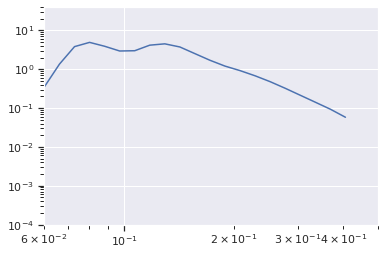

In [68]:
plt.plot(ww1719ef.f.values,coupled_model_ww.EF.sel(NY=nj['sodaB']-100,NX=ni['sodaB']))
plt.loglog()
plt.xlim(0.06,0.5)
plt.ylim(10**-4,4e1)
plt.show()

In [69]:
# ww1719ef.f.values
np.trapz(coupled_model_ww.EF.sel(NY=nj['sodaB']-100,NX=ni['sodaB']),ww1719ef.f.values)**(0.5)*4

2.7579191797820095

In [168]:
coupled_model_ww_mean.HS.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-4)

<xarray.DataArray 'HS' ()>
array(1.4658917, dtype=float32)

In [165]:
coupled_model_ww_mean.HS.sel(NY=nj['sodaB']-10,NX=ni['sodaB']-10)

<xarray.DataArray 'HS' ()>
array(2.3396432, dtype=float32)

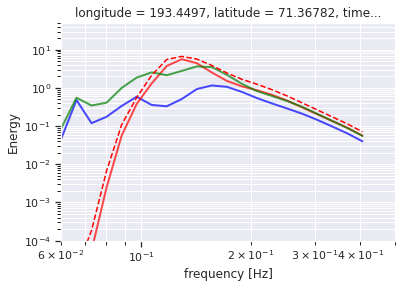

In [206]:
# plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-6,NX=ni['sodaB']-4))

# plt.plot(ww1719ef.f.values,coupled_model_ww5.EF.sel(NY=nj['sodaB']-6,NX=ni['sodaB']-4))

# plt.plot(ww1719ef.f.values,coupled_model_ww5.EF.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-4))
plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-4),c='b',lw=2,alpha=0.7)
# plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-200,NX=ni['sodaB']-4))
plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-10,NX=ni['sodaB']-10),c='r',lw=2,alpha=0.7)

plt.plot(ww1719ef.f.values,coupled_model_ww_mean.EF.sel(NY=nj['sodaB']-30,NX=ni['sodaB']-15),c='g',lw=2,alpha=0.7)


###
ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2018-11-01')[1].plot(c='r',ls='--')
# ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2017-11-01')[1].plot(c='k',ls='--')
# ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2019-11-01')[1].plot(c='0.5',ls='--')

plt.loglog()
plt.xlim(0.06,0.5)
plt.ylim(10**-4,5e1)
plt.xlabel('frequency [Hz]')
plt.ylabel('Energy')
plt.grid(True,which='both')
plt.show()

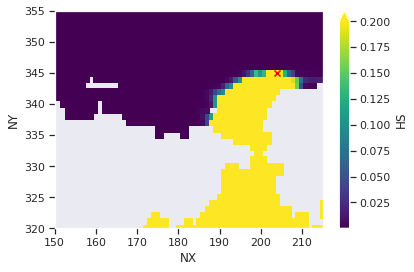

In [121]:
coupled_model_ww_mean.HS.plot(vmax=0.2)
plt.scatter(208-4,nj['sodaB']-6,marker='x',c='r')
plt.xlim(150,215)
plt.ylim(320,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

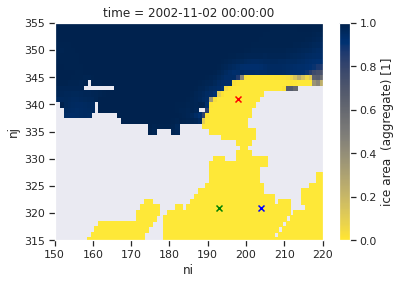

In [188]:
coupled_model_cice.aice_d.plot(cmap='cividis_r')
# plt.scatter(208-4,nj['sodaB']-6,marker='x',c='r')
plt.scatter(208-4,nj['sodaB']-30,marker='x',c='b')
plt.scatter(208-15,nj['sodaB']-30,marker='x',c='g')
plt.scatter(208-10,nj['sodaB']-10,marker='x',c='r')
plt.xlim(150,220)
plt.ylim(315,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

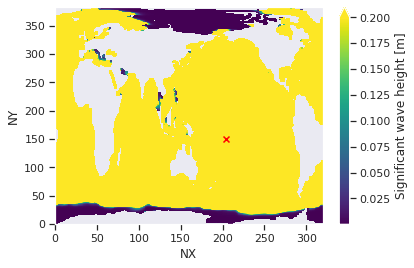

In [152]:
coupled_model_ww5.HS.plot(vmax=0.2)
plt.scatter(208-4,nj['sodaB']-200,marker='x',c='r')
# plt.xlim(150,215)
# plt.ylim(320,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

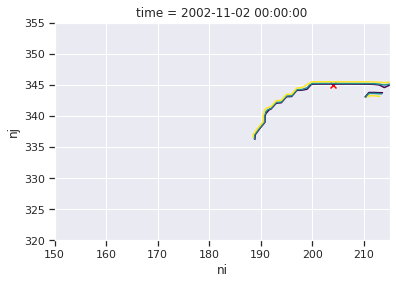

In [135]:
coupled_model_cice.aice_d.squeeze().plot.contour(levels=[0.15,0.25,0.5])
plt.scatter(208-4,nj['sodaB']-6,marker='x',c='r')
plt.xlim(150,215)
plt.ylim(320,355)
# plt.scatter(nj['sodaB']-30, ni['sodaB'],marker='x',c='r',size=10)
plt.show()

In [192]:
ww1719beau

<xarray.Dataset>
Dimensions:    (ni: 320, nj: 84, time: 4380)
Coordinates:
    longitude  (nj, ni) float32 ...
    latitude   (nj, ni) float32 ...
  * time       (time) datetime64[ns] 2017-01-01 ... 2019-12-31T18:00:00
    mask       (nj, ni) bool False False False False ... False False False False
Dimensions without coordinates: ni, nj
Data variables:
    MAPSTA     (nj, ni) int16 ...
    dpt        (time, nj, ni) float32 ...
    uwnd       (time, nj, ni) float32 ...
    vwnd       (time, nj, ni) float32 ...
    ast        (time, nj, ni) float32 ...
    ice        (time, nj, ni) float32 ...
    hs         (time, nj, ni) float32 ...
    lm         (time, nj, ni) float32 ...
    t02        (time, nj, ni) float32 ...
    t0m1       (time, nj, ni) float32 ...
    t01        (time, nj, ni) float32 ...
    fp         (time, nj, ni) float32 ...
    dir        (time, nj, ni) float32 ...
    spr        (time, nj, ni) float32 ...
    dp         (time, nj, ni) float32 ...
Attributes:
    WAVEWATCH_III_version_number:  5.16
    WAVEWATCH_III_switches:        F90 NOGRB NOPA LRB4 NC4 PR3 UQ FLX0 LN1 ST...
    product_name:                  ww3.20000101.nc
    area:                          POP 1 degree grid (gx1v6b)
    latitude_resolution:           n/a
    longitude_resolution:          n/a
    southernmost_latitude:         -79.22052
    northernmost_latitude:         89.70641
    westernmost_longitude:         1.4731102E-02
    easternmost_longitude:         359.9960
    minimum_altitude:              -12000 m
    maximum_altitude:              9000 m
    altitude_resolution:           n/a
    start_date:                    2000-01-01 00:00:00
    stop_date:                     2000-01-01 18:00:00
    nco_openmp_thread_number:      1
    history:                       Fri Jun 26 16:57:55 2020: ncrcat cicefsdww...
    NCO:                           netCDF Operators version 4.7.9 (Homepage =...

In [197]:
ww1719ef.ef.sel(nj=nj['sodaB']-10,ni=ni['sodaB']-10,time='2018-11-01')[0]

<xarray.DataArray 'ef' (f: 25)>
array([5.187822e-10, 1.073148e-08, 2.493404e-07, 1.095380e-06, 7.097297e-06,
       1.620678e-05, 2.465322e-05, 2.660914e-04, 6.146821e-03, 5.159676e-02,
       2.982422e-01, 1.392692e+00, 3.399139e+00, 5.473507e+00, 5.418143e+00,
       3.721037e+00, 2.082450e+00, 1.283081e+00, 9.033954e-01, 6.824722e-01,
       4.821395e-01, 3.221779e-01, 2.079277e-01, 1.352979e-01, 8.400936e-02],
      dtype=float32)
Coordinates:
    longitude  float32 ...
    latitude   float32 ...
  * f          (f) float32 0.04118 0.045298003 ... 0.36873826 0.40561208
    time       datetime64[ns] 2018-11-01
Attributes:
    long_name:      wave_elevation_spectrum
    standard_name:  power_spectral_density_of_surface_elevation
    globwave_name:  power_spectral_density_of_surface_elevation
    units:          m2 s
    valid_min:      -30000
    valid_max:      32000

## Check bit for bit run

In [3]:
newrun = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/cesm23iws1tsks_bittest1.cice.h1.2012-01-31.nc')
oldrun = xr.open_dataset(
    '/glade/scratch/vcooper/cesm23iws1tsks_bittest1/run/refrun/cesm23iws1tsks.cice_nh.h1.2012-01.nc')

In [34]:
oldrun.aice_d[-1]

<xarray.DataArray 'aice_d' (nj: 104, ni: 320)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    TLAT     (nj, ni) float32 30.37926 30.380173 30.381998 ... nan nan nan
    TLON     (nj, ni) float32 320.55792 321.67377 322.78964 ... nan nan nan
    ULAT     (nj, ni) float32 30.604626 30.60602 30.60834 ... nan nan nan
    ULON     (nj, ni) float32 321.1156 322.2312 323.3468 ... nan nan nan
    time     object 2012-02-01 00:00:00
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [36]:
icediff = newrun.aice_d.sel(nj=slice(280,384)) - oldrun.aice_d[-1]

In [40]:
sstdiff = newrun.sst_d.sel(nj=slice(280,384)) - oldrun.sst_d[-1]
uwinddiff = newrun.uatm_d.sel(nj=slice(280,384)) - oldrun.uatm_d[-1]

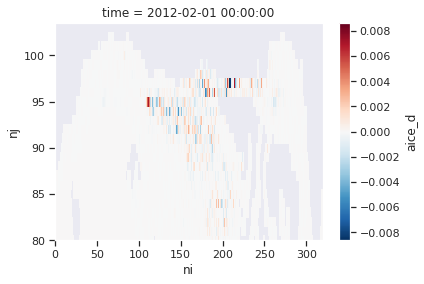

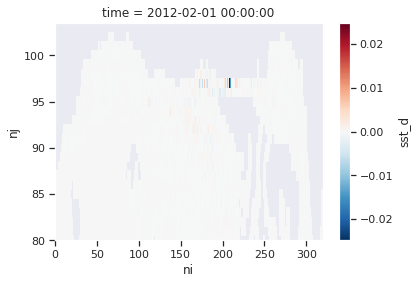

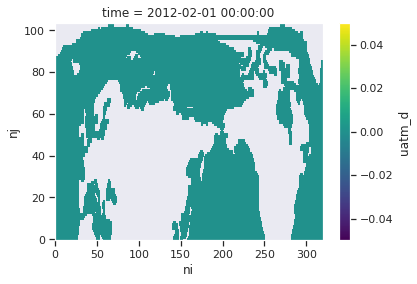

In [42]:
icediff.plot()
plt.ylim(80,)
plt.show()

sstdiff.plot()
plt.ylim(80,)
plt.show()

uwinddiff.plot()
plt.show()

In [31]:
newrun.uatm_d

<xarray.DataArray 'uatm_d' (time: 1, nj: 384, ni: 320)>
[122880 values with dtype=float32]
Coordinates:
  * time     (time) object 2012-01-06 00:00:00
    TLON     (nj, ni) float32 ...
    TLAT     (nj, ni) float32 ...
    ULON     (nj, ni) float32 ...
    ULAT     (nj, ni) float32 ...
Dimensions without coordinates: nj, ni
Attributes:
    units:          m/s
    long_name:      atm velocity (x)
    cell_measures:  area: uarea
    cell_methods:   time: mean
    time_rep:       averaged

In [45]:
ww1719ef_beau_cat.f

<xarray.DataArray 'f' (f: 25)>
array([0.04118 , 0.045298, 0.049828, 0.054811, 0.060292, 0.066321, 0.072953,
       0.080248, 0.088273, 0.0971  , 0.10681 , 0.117491, 0.12924 , 0.142165,
       0.156381, 0.172019, 0.189221, 0.208143, 0.228957, 0.251853, 0.277038,
       0.304742, 0.335217, 0.368738, 0.405612], dtype=float32)
Coordinates:
  * f        (f) float32 0.04118 0.045298003 ... 0.36873826 0.40561208
Attributes:
    long_name:      wave_frequency
    standard_name:  wave_frequency
    units:          s-1
    axis:           Hz

In [46]:
1/ww1719ef_beau_cat.f

<xarray.DataArray 'f' (f: 25)>
array([24.283632 , 22.076029 , 20.069117 , 18.244652 , 16.586046 ,
       15.078224 , 13.707477 , 12.461342 , 11.328494 , 10.298631 ,
        9.3623905,  8.511265 ,  7.7375126,  7.034103 ,  6.394638 ,
        5.813308 ,  5.2848253,  4.8043866,  4.367624 ,  3.9705675,
        3.6096067,  3.2814608,  2.9831457,  2.7119508,  2.4654098],
      dtype=float32)
Coordinates:
  * f        (f) float32 0.04118 0.045298003 ... 0.36873826 0.40561208